# PySpice_EyePoint_CurveTracer
## часть проекта по восстановлению электронной схемы характериографом

## https://github.com/vasily84/PySpice_CurveTracer 


### Необходимы - python3.x, sklearn,PySpice

### необходимые библиотеки -
### PySpice - симуляция электронных схем из Python
https://pyspice.fabrice-salvaire.fr/ 

https://github.com/FabriceSalvaire/PySpice

### scikit-learn библиотека машинного обучения
https://scikit-learn.org/stable/index.html

## Как использовать?
### Необходимо задать рабочую папку программы в переменной FILEBASE_ROOT ( ячейка ниже). 
### Варианты запуска программы :

* Первый запуск - Папка задана, но не существует: программа создаст папку и скачает библиотеку spice компонентов из github, затем сгенерирует синтетические данные для схем, описанных в коде и построит модели машинного обучения для них. Для каждой модели создается отдельная папка внутри FILEBASE_ROOT. Туда же пишется её .pickle образ. При последующих запусках модели будут подгружаться с диска.


* Второй и прочие запуски - (папка FILEBASE_ROOT содержит библиотеку spice компонентов и дополнительные папки с обученными моделями) обученные модели загружаются с диска.


* При необходимости переобучить модель - можно удалить файл модели .pickle из ее подпапки или всю её подпапку - при следующем запуске ноутбука модель будет перетренирована.


* При необходимости перенести ноутбук целиком на другой компьютер можно скопировать папку FILEBASE_ROOT и указать правильные пути к ней, но следует помнить о возможной несовместимости .pickle объектов для разных версий питона и библиотек.

### Код написан последовательно сверху вниз-
### для тестирования и исследовательских целей удобнее всего запускать ноутбук целиком Menu->Kernel->Restart & Run All, помещая необходимый дополнительный код в самые нижние ячейки ноутбука, и затем дописывая и запуская ячейки


In [1]:
FILEBASE_ROOT = 'E:\EyePoint' # путь к рабочей папке программы

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import itertools
from sklearn import __version__ as sk_version
from scipy.signal import resample

import PySpice
import PySpice.Logging.Logging as Logging
from PySpice.Spice.Netlist import Circuit
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Doc.ExampleTools import find_libraries
from PySpice.Unit import *

import os
import uuid
import random
import requests
import zipfile
import json

plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (10,8)

logger = Logging.setup_logging()
PySpice.show_version()

print('sklearn version '+sk_version)

Circuit_Set = set() # set of all availible curcuits 

PySpice Version 1.4.3
sklearn version 1.0.2


### проверяем пути к рабочей папке, при необходимости подгружаем spice библиотеки компонентов и обученные модели с github

In [3]:
def download_and_unzip(filePath):
    print('downloading started..')
                       
    url = 'https://github.com/vasily84/PySpice_CurveTracer/raw/main/spice_library.zip'
    # Downloading the file by sending the request to the URL
    req = requests.get(url)

    zipName = os.path.join(filePath,'temp.zip')
    print('from '+str(url)+'\ndownloaded '+str(len(req.content))+' bytes')
    
    # Writing the file to the local file system
    with open(zipName,'wb') as output_file:
        output_file.write(req.content)
    print('downloading completed, UnZip started..')
    
    # unzip 
    with zipfile.ZipFile(zipName, 'r') as zip_ref:
        zip_ref.extractall(filePath)
        
    os.remove(zipName)
    print('UnZip completed..')
    
    
# проверяем пути к рабочей папке,
# при необходимости подгружаем spice библиотеки компонентов
# и обученные модели с github
if not os.path.exists(FILEBASE_ROOT):
    os.makedirs(FILEBASE_ROOT)
    download_and_unzip(FILEBASE_ROOT)

print('\nsimulation dataset on:\n'+FILEBASE_ROOT)

libraries_path = os.path.join(FILEBASE_ROOT,'spice_library')
print('\nspice models library on:\n'+libraries_path)
spice_library = SpiceLibrary(libraries_path)
print(spice_library['1N4148'])


simulation dataset on:
E:\EyePoint

spice models library on:
E:\EyePoint\spice_library
E:\EyePoint\spice_library\diode\switching\1N4148.lib


### код CreateCVC базируется на библиотеке MySpice
https://github.com/LukyanovM/MySpice

используем эту библиотеку, ибо она максимально близко имитирует прибор
EyePoint https://eyepoint.physlab.ru/ru/

In [4]:
class CurveTracer_Settings():
    """ EyePoint hardware settings struct"""
    def __init__(self,F=100,V=5.,Rcs=4750.,SNR=40.0,lendata=100,cycle=3,json=None):
        self.F = F
        self.V = V
        self.Rcs = Rcs
        self.SNR = SNR
        self.lendata = lendata
        self.cycle = cycle
        if json is not None:
            self.from_json(json)
    
    def to_numpy(self):
        arr = np.array([self.F, self.V, self.Rcs, self.SNR, self.lendata, self.cycle])
        return arr
    
    def from_numpy(self,arr):
        self.F = arr[0]
        self.V = arr[1]
        self.Rcs = arr[2]
        self.SNR = arr[3]
        self.lendata = int(arr[4])
        self.cycle = int(arr[5])
        return self
        
    def __str__(self):
        s = 'F='+str(self.F)+' V='+str(self.V)+' lendata='+str(self.lendata)+' Rcs='+str(self.Rcs)+' cycle='+str(self.cycle)+' SNR='+str(self.SNR)
        return s
    
    def __eq__(self,obj):
        """ сравниваем по критерию - частота, напряжение, число точек,вн.сопротивление """
        lendata_ok = (self.lendata==obj.lendata)
        F_ok = abs(self.F-obj.F) <= 0.1 # точность сравнения 0.1 Гц
        V_ok = abs(self.V-obj.V) <= 0.1 # точность сравнения 0.1 Вольт
        Rcs_ok = abs(self.Rcs-obj.Rcs) <=0.1 # точность 0.1 Ом
        return (lendata_ok and F_ok and V_ok)
    
    def __hash__(self):
        """ поддержка hash для работы с множествами"""
        return hash((self.F,self.V,self.lendata,self.Rcs))
    
    def from_json(self,jsonRec):
        #print(jsonRec['iv_curves'][0]['measurement_settings'])
        self.F = jsonRec['iv_curves'][0]['measurement_settings']['probe_signal_frequency']
        self.V = jsonRec['iv_curves'][0]['measurement_settings']['max_voltage']
        self.Rcs = jsonRec['iv_curves'][0]['measurement_settings']['internal_resistance']
        sr = jsonRec['iv_curves'][0]['measurement_settings']['sampling_rate']
        self.lendata = sr//self.F
        return self
        

def CreateCVC(circuit,ct):
    """ просимулировать схему в PySpice. circuit - схема, ct - настройки симуляции"""
    cycle = ct.cycle
    lendata = ct.lendata
    period = 1 / ct.F
    rms_voltage = ct.V / np.sqrt(2)
    # добавляем испытательный щуп в схему
    circuit.R('cs', 'input', 'input_dummy', ct.Rcs)
    circuit.AcLine('Current', circuit.gnd, 'input_dummy', rms_voltage=rms_voltage, frequency=ct.F)
    
    simulator = circuit.simulator()
    analysis = simulator.transient(step_time=period / lendata, end_time=period * cycle)
    analysis.input_dummy = analysis.input_dummy[len(analysis.input_dummy)-lendata:len(analysis.input_dummy)]
    analysis.VCurrent = analysis.VCurrent[len(analysis.VCurrent)-lendata:len(analysis.VCurrent)]
# Расчитываем шум независмо для тока и напряжения исходя из среднеквадратичных значений и одинакового SNR
    avg_V_db = 10 * np.log10(np.mean(np.array(analysis.input_dummy, dtype=float) ** 2))
    avg_Vnoise_db = avg_V_db - ct.SNR
    Vnoise = np.random.normal(0, np.sqrt(10 ** (avg_Vnoise_db / 10)), len(analysis.input_dummy))
    analysis.input_dummy = np.array(analysis.input_dummy, dtype=float) + Vnoise
    avg_I_db = 10 * np.log10(np.mean(np.array(analysis.VCurrent, dtype=float) ** 2))
    avg_Inoise_db = avg_I_db - ct.SNR
    Inoise = np.random.normal(0, np.sqrt(10 ** (avg_Inoise_db / 10)), len(analysis.VCurrent))
    analysis.VCurrent = np.array(analysis.VCurrent, dtype=float) + Inoise
    # удаляем испытательный щуп из схемы
    circuit.Rcs.detach()
    circuit.VCurrent.detach()
    return analysis

class CAnalysis():
    def __init__(self,VCurrent=None,input_dummy=None,json=None):
        self.VCurrent = VCurrent
        self.input_dummy = input_dummy
        if json is not None:
            self.from_json(json)
    
    def from_json(self,jsonRec):
        self.VCurrent = jsonRec["iv_curves"][0]["currents"]
        self.input_dummy = jsonRec["iv_curves"][0]["voltages"]
        return self
        
def load_JSON_Records(filePath):
    """ загрузка с диска набора снятых прибором данных - самого сигнала и параметров его съемки """
    with open(filePath, "r") as jfile:
        J = json.load(jfile)
    return J["elements"][0]["pins"]

def plot_analysis_IV(analysis,label='',ax=None):
    """ plot I(V) curve for analysis """
    if ax is None:
        plt.plot(analysis.input_dummy, analysis.VCurrent,label=label)
        plt.title('I(V)')
        plt.xlabel('Напряжение [В]')
        plt.ylabel('Сила тока [А]')
        return
    ax.plot(analysis.input_dummy, analysis.VCurrent,label=label)
    ax.set_title('I(V)')
    ax.set_xlabel('Напряжение [В]')
    ax.set_ylabel('Сила тока [А]')
    

Cоставим множество из доступных варианов режимов работы прибора

In [5]:
# варианты настройки пробора по умолчанию - перечисляем врукопашную 
ct_List = list()
ct = CurveTracer_Settings(F=1.,V=3.3,lendata=100,Rcs=475.)
ct_List.append(ct)
ct = CurveTracer_Settings(F=100.,V=5.,lendata=100,Rcs=4750.)
ct_List.append(ct)
ct = CurveTracer_Settings(F=100_000,V=12.,lendata=20,Rcs=47500.)
ct_List.append(ct)

try: # просканируем папку, добавим оттуда варианты настройки прибора
    path_json = os.path.join(FILEBASE_ROOT,'RealSignalFolder')
    fileList = [f for f in os.listdir(path_json) if f.endswith('.json')]
    
    # просмотрим доступные файлы, составим множество из конфигураций прибора
    for f1 in fileList:
        ff = os.path.join(FILEBASE_ROOT,'RealSignalFolder',f1)
        jRecs = load_JSON_Records(ff)
        for j in jRecs:
            ct = CurveTracer_Settings(json=j)
            #analysis = CAnalysis(json=j)
            ct_List.append(ct)
finally:
    # удалим дубликаты
    ct_List_uniq = []
    for ct in ct_List:
        if ct not in ct_List_uniq:
            ct_List_uniq.append(ct)
    ct_List = ct_List_uniq
    print('**list of curve tracer settings:')
    for ct in ct_List:
         print(ct)


**list of curve tracer settings:
F=1.0 V=3.3 lendata=100 Rcs=475.0 cycle=3 SNR=40.0
F=100.0 V=5.0 lendata=100 Rcs=4750.0 cycle=3 SNR=40.0
F=100000 V=12.0 lendata=20 Rcs=47500.0 cycle=3 SNR=40.0


#### пример использования CreateCVC

In [6]:
%%script false
%time
circuit = Circuit('RD')
circuit.include(spice_library['1N4148'])
circuit.R(1,'input',1,10@u_kOhm)
circuit.X('D1', '1N4148', 1, circuit.gnd)
circuit.R(2,'input',circuit.gnd,20@u_kOhm)

analysis = CreateCVC(circuit,CurveTracer_Settings())
        
#plt.grid()
plt.plot(analysis.input_dummy, analysis.VCurrent)
plt.xlabel('Напряжение [В]')
plt.ylabel('Сила тока [А]')
plt.show()



Couldn't find program: 'false'


### как построена база?
каждой схеме соответствует папка, в которой хранятся файлы массивов симуляции c номиналами схемы и параметрами прибора,и circuit файл - информация о самой схеме

In [7]:
def save_cir_analysis(fileName,circuit_params,curve_params,analysis):
    """ save circuit nominals,curve tracer parameters, voltage and current arrays to file"""
    with open(fileName, 'wb') as f:
        np.save(f,circuit_params)
        np.save(f,curve_params)
        np.save(f,analysis.VCurrent)
        np.save(f,analysis.input_dummy)
    
def make_sure_path(path_title):
    """ create path if path not exist, return full path """
    dirName = os.path.join(FILEBASE_ROOT,path_title)
    if not os.path.exists(dirName):
        os.makedirs(dirName)
    return dirName

def save_circuit(dirName,circuit):
    """ save sample circuit on disk """
    fileName = os.path.join(dirName,circuit.title+'.cir')
    with open(fileName,'w') as f:
        f.write(str(circuit))
        

In [8]:
def load_circuit_dataset(path_dataset,ct=None,shuffle=True,max_files=None):
    """ load dataset from circuit folder.
    return X,y """
    fileList = [f for f in os.listdir(path_dataset) if f.endswith('.npy')]
    
    if shuffle: 
        random.shuffle(fileList)
        
    if not max_files is None:
        max_files = min(max_files,len(fileList))
        fileList=fileList[0:max_files]
    
    X_data,y_data=[],[]
    
    for fileName in tqdm(fileList): # process files
        with open(os.path.join(path_dataset,fileName), 'rb') as f:
            circuit_params = np.load(f)
            curve_params = np.load(f)
            VCurrent = np.load(f)
            input_dummy = np.load(f)  
                                
            if not ct is None: 
                ct0 = CurveTracer_Settings().from_numpy(curve_params)
                if not (ct0==ct):
                    continue # пропускаем сигналы с неподходящими параметрами
                    
        # append data to arrays
        y_data.append(circuit_params)
        X_data.append([VCurrent,input_dummy])
        
    return np.array(X_data),np.array(y_data)

## препроцессор данных для моделей -
### делает преобразование фурье, прореживание и прочие манипуляции со входными сигналами

#### Мотивация к добавлению в признаковое пространство конкретных алгебраических величин (закон Ома):

Ток $I=V/R$

Сопротивление $R=V/I$

Проводимость $\sigma=1/R=I/V$

Напряжение на конденсаторе $V=C*Q$

Заряд конденсатора $Q=\int Idt \sim \sum {I}$ 

Емкость конденсатора $C=V/Q$ или $C \sim V/\sum {I}$

Диф. сопротивление $R_d= \frac {\Delta {V}} {\Delta{I}}$

Диф. Проводимость $\sigma_d=1/R_d=\Delta {I}/\Delta {V}$

Напряжение на индуктивности $ V = -L \frac {\Delta{I}} {\Delta{t}} \sim L\Delta{I}$

Величина индуктивности $L \sim \frac {V} {\Delta{I}}$

##### Итого - параметры R, C, L линейно связаны с сигналами V, I, их производными (изменениями от точке к точке) и интегралами (суммами)


#### Мотивация к использованию логарифмов:

$\log {(AB)} = \log {A}+\log {B} $

$\log {\frac {A} {B}} = \log {A}-\log{B}$

##### Итого - можно взять логарифмы от исходных сигналов, их производных и интегралов, и линейная модель их свяжет с логарифмами искомых параметров R, C, L. 

In [9]:
from sklearn.preprocessing import FunctionTransformer,StandardScaler
from scipy.fft import rfft

def my_xgb_transform_function(X):
    """ feature engineering on raw analysis signal data.
    Transformations - fft image, input signal resampling etc.""" 
    Xa = []
    for x in X:
        I_signal = x[:len(x)//2] # current      
        V_signal = x[len(x)//2:] # input voltage - not use
        I_fft = rfft(I_signal)
        I_fft = I_fft[:20] # use only first 20 points on freq domain
        I_abs = np.abs(I_fft)
        I_angle = np.angle(I_fft)
        I_real = np.real(I_fft)
        I_imag = np.imag(I_fft)
        
        V_fft = rfft(V_signal)
        V_fft = V_fft[:20] # use only first 20 points on freq domain
        V_abs = np.abs(V_fft)
        V_angle = np.angle(V_fft)
        V_real = np.real(V_fft)
        V_imag = np.imag(V_fft)

        x1 = np.hstack((x,I_abs,I_angle,I_real,I_imag,V_abs,V_angle,V_real,V_imag))
        Xa.append(x1)
        
    return np.array(Xa)

def my_rfft_transform_function(X):
    """ feature engineering on raw analysis signal data.
    Transformations - fft image, input signal resampling etc.""" 
    Xa = []
    for x in X:
        I_signal = x[:len(x)//2] # current      
        V_signal = x[len(x)//2:] # input voltage - not use
        I_fft = rfft(I_signal)
        
        I_abs = np.abs(I_fft)
        I_angle = np.angle(I_fft)
        I_real = np.real(I_fft)
        I_imag = np.imag(I_fft)
        
        V_fft = rfft(V_signal)
        
        V_abs = np.abs(V_fft)
        V_angle = np.angle(V_fft)
        V_real = np.real(V_fft)
        V_imag = np.imag(V_fft)

        x1 = np.hstack((I_abs,I_angle,I_real,I_imag,V_abs,V_angle,V_real,V_imag))
        Xa.append(x1)
        
    return np.array(Xa)

def my_linear_transform_function(X):
    """ feature engineering on raw analysis signal data.
    Transformations - fft image, input signal resampling etc.""" 
    Xa = []
    for x in X:
        I_signal = x[:len(x)//2] # current      
        V_signal = x[len(x)//2:] # input voltage - not use
        Q_signal = np.cumsum(I_signal)
        dI_signal = np.diff(I_signal)
        dV_signal = np.diff(V_signal)
        
        x1 = np.hstack((I_signal,V_signal,Q_signal,dI_signal,dV_signal))
        Xa.append(x1)
        
    return np.array(Xa)

MyXGBTransformer = FunctionTransformer(my_xgb_transform_function)
MyRfftTransformer = FunctionTransformer(my_rfft_transform_function)
MyLinearTransformer = FunctionTransformer(my_linear_transform_function)

## базовый класс схем

In [10]:
import pickle
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoCV,RidgeCV
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor,RandomForestRegressor
from sklearn.multioutput import RegressorChain
from sklearn.pipeline import make_pipeline
from copy import deepcopy

class BaseCircuitModel():
    """ base class for circuit models. Provide training, data preprocessing,
    prediction for nominal values """
    def __init__(self,title='baseAbstract',modelDir=None,modelName=None,estimator=None,ct=None):
        self.title = title
        self.estimator = estimator
        self.modelDir = os.path.join(FILEBASE_ROOT,self.title) if (modelDir is None) else modelDir  
        make_sure_path(self.modelDir)
        self.modelName = title+'.pickle' if (modelName is None) else modelName   
        self.modelFileName = os.path.join(self.modelDir,self.modelName)
        self.optimize_save_flag = False
        
        if ct is None:
            ct = CurveTracer_Settings()
            
        # deepcopy необходим, т.к. при загрузке с диска self.ct пересоздается 
        self.ct = deepcopy(ct) 
        
        try:
            self.load_model()
            return 
        except OSError as e:
            print(e)
            
        print('rebuild model ...')
        self.build_model()
        
    
    def load_model(self):
        with open(self.modelFileName, "rb") as f:
                self.model = pickle.load(f)
                self.rank = self.model.rank # number of circuit variative nominals
                self.ct = CurveTracer_Settings().from_numpy(self.model.ct)
        
    def save_model(self):
        with open(self.modelFileName, "wb") as f:
                self.model.rank = self.rank
                self.model.ct = self.ct.to_numpy()
                pickle.dump(self.model, f)
        
    def write_dataset(self,Xvals):
        """ circuit batch simulation over params Xvals"""
        for xval in tqdm(Xvals): # walk over nominals in circuit and create I/V curves
            cir_params = np.array(xval)
            circuit = self.build_circuit(cir_params)
            analysis = CreateCVC(circuit,ct=self.ct)
            fileName = os.path.join(self.modelDir,uuid.uuid4().hex+'.npy')
            save_cir_analysis(fileName,cir_params,self.ct.to_numpy(),analysis)

    def load_dataset(self):
        """ load dataset from disk"""
        X_data,y_data = load_circuit_dataset(self.modelDir,ct=self.ct)
        ADim = X_data.shape[0]
        X_data = X_data.reshape(ADim,-1)
        if self.rank==1: # fit shape 1d regression or Nd regression 
            y_data = y_data.reshape(-1)
        else:
            y_data = y_data.reshape(ADim,-1)
            
        return X_data,y_data
        
    def build_model(self,save_model=True, test_model=True ): 
        print('dataset for model '+self.title+' is loading, please wait..')
        
        if self.estimator is None:
            baseEstimator = GradientBoostingRegressor()
            
            if self.rank>1:
                self.model = make_pipeline(MyXGBTransformer,RegressorChain(baseEstimator))
            else:
                self.model = make_pipeline(MyXGBTransformer,baseEstimator)
        else:
            self.model = self.estimator
        
        try:
            X_data,y_data = self.load_dataset()
        except BaseException as e:
            print(e)
            print('rebuild dataset ...')
            self.rebuild_dataset()
            X_data,y_data = self.load_dataset()
        
        print('model '+self.title+' is training, please wait..')
        self.model.fit(X_data,y_data)
        self.model.rank = self.rank
        
        if save_model:
            self.save_model()
            self.load_model()
        
        if test_model:
            print('test_model() routine for '+self.title+' model:')
            self.test_model()
    
    def test_model(self):
        print('!!WARNING : test_model() routine for '+self.title+' model not implemented')
            
    def predict_from_model(self,analysis0,start_minimization=False):
        """ predict X values for circuit, best fitted to analysis0 """
        if not len(analysis0.VCurrent)==self.ct.lendata:
            print('len(A)='+str(len(analysis0.VCurrent)),end='')
            print(' len(B)='+str(self.ct.lendata))
            print('do resampling')
            VCurrent = resample(analysis0.VCurrent,self.ct.lendata)
            input_dummy = resample(analysis0.input_dummy,self.ct.lendata)
            X = np.array([VCurrent,input_dummy]).reshape(-1)
        else:
            X = np.array([analysis0.VCurrent,analysis0.input_dummy]).reshape(-1)
        
        a = self.model.predict([X])[0]
        if start_minimization:
            a,_ = self.optimize_from_X(analysis0,a)
        
        return a
        
    def misfit(self,analysis0, Xvals=None,start_minimization=False):
        """ calculate mse for current from circuit from Xval simulation and from analysis"""
        if Xvals is None:
            Xvals = self.predict_from_model(analysis0)
        
        if start_minimization:
            Xvals,_ = self.optimize_from_X(analysis0,Xvals)
            
        circuit = self.build_circuit(Xvals)
        analysis1 = CreateCVC(circuit,self.ct)
        
        len_0 = len(analysis0.VCurrent)
        len_1 = len(analysis1.VCurrent)
        if not len_0==len_1:
            print('do resample..')
            len_max = max(len_o,len_1)
            A_0 = resample(analysis0.VCurrent,len_max)
            A_1 = resample(analysis0.VCurrent,len_max)
            return mean_squared_error(A_1,A_0)
            
        return mean_squared_error(analysis1.VCurrent,analysis0.VCurrent)
    
    def _optimize_func(self,Xvals):      
        circuit = self.build_circuit(Xvals)
        analysis1 = CreateCVC(circuit,self.ct)
        
        if self.optimize_save_flag:
            fileName = os.path.join(self.modelDir,'o_'+uuid.uuid4().hex+'.npy')
            save_cir_analysis(fileName,Xvals,ct_default_settings.to_numpy(),analysis1)

        return mean_squared_error(analysis1.VCurrent,self._analysis0.VCurrent)

    def optimize_from_X(self,analysis0,Xvalues = None):
        if Xvalues is None:
            Xvalues = self.predict_from_model(analysis0).reshape(-1)
        self._analysis0 = analysis0 #
        
        optimize_result = minimize(self._optimize_func,Xvalues)
        
        return (optimize_result.x, optimize_result)
        
    


### Реализация конкретных схем из резисторов, емкостей, индуктивностей и диодов 
## rank 1, rank 2

In [11]:
%%time
######################################################################

class R_circuit(BaseCircuitModel):
    def __init__(self,modelName=None,estimator=None,ct=None):
        self.rank = 1
        super().__init__('R',modelName=modelName,estimator=estimator,ct=ct)
            
    def build_circuit(self,Xvals): 
        if isinstance(Xvals, float):
            r1 = Xvals
        elif isinstance(Xvals, list):
            r1 = Xvals[0]
        else: # it is numpy array
            r1 = Xvals.item()
        r1 = np.abs(r1)
        circuit = Circuit('R')
        circuit.R(1,'input',circuit.gnd,r1@u_kOhm)
        return circuit
    
    def rebuild_dataset(self):
        self.write_dataset(np.random.uniform(0.1,100,size=50))
        self.write_dataset(np.random.uniform(0.0,5,size=50))
        
        
    def test_model(self):
        print('actual r \t predicted r \t acc dr/r ')
        for r in np.array([0.1, 1, 1.1, 3., 10., 15., 22., 30., 50., 70., 75., 98., 100.]):
            analysis0 = CreateCVC(self.build_circuit(r),self.ct)
            x = self.predict_from_model(analysis0)
            acc = np.abs((x-r)/r)
            print(str(r),str(x),str(acc),sep='\t')
            
Circuit_Set.add(R_circuit('R1',ct=ct_List[0]))
Circuit_Set.add(R_circuit('R2',ct=ct_List[1]))
Circuit_Set.add(R_circuit('R3',ct=ct_List[2]))


######################################################################

class C_circuit(BaseCircuitModel):
    def __init__(self,modelName=None,estimator=None,ct=None):
        self.rank = 1
        super().__init__('C',modelName=modelName,estimator=estimator,ct=ct)
        
    def build_circuit(self,Xvals): 
        if isinstance(Xvals, float):
            c1 = Xvals
        elif isinstance(Xvals, list):
            c1 = Xvals[0]
        else: # it is numpy array
            c1 = Xvals.item()
        c1 = np.abs(c1)
        circuit = Circuit('C')
        circuit.C(1,'input',circuit.gnd,c1@u_uF)
        return circuit
    
    def rebuild_dataset(self):
        self.write_dataset(np.random.uniform(1e-3,100.,size=50))
        
    def test_model(self):
        print('actual c \t predicted c \t acc dc/c ')
        
        for c in np.array([0.1, 1, 1.1, 3., 10., 15., 22., 30., 50., 70., 75., 98., 100.]):
            analysis0 = CreateCVC(self.build_circuit(c),self.ct)
            x = self.predict_from_model(analysis0)
            acc = np.abs((x-c)/c)
            print(str(c),str(x),str(acc),sep='\t')
    
Circuit_Set.add(C_circuit('C1',ct=ct_List[0]))
Circuit_Set.add(C_circuit('C2',ct=ct_List[1]))
Circuit_Set.add(C_circuit('C3',ct=ct_List[2]))

    
######################################################################

class L_circuit(BaseCircuitModel):
    def __init__(self,modelName=None,estimator=None,ct=None):
        self.rank = 1
        super().__init__('L',modelName=modelName,estimator=estimator,ct=ct)
            
    def build_circuit(self,Xvals): 
        if isinstance(Xvals, float):
            l1 = Xvals
        elif isinstance(Xvals, list):
            l1 = Xvals[0]
        else: # it is numpy array
            l1 = Xvals.item()
        l1 = np.abs(l1)
        circuit = Circuit('L')
        circuit.L(1,'input',circuit.gnd,l1@u_uH)
        return circuit
    
    def rebuild_dataset(self):
        self.write_dataset(np.random.uniform(1e-3,500,size=1000))
        
    def test_model(self):
        print('actual c \t predicted c \t acc dc/c ')
        
        for l in np.array([0.1, 1, 1.1, 3., 10., 15., 22., 30., 50., 70., 175., 398., 700.]):
            analysis0 = CreateCVC(self.build_circuit(l),self.ct)
            x = self.predict_from_model(analysis0)
            acc = np.abs((x-l)/l)
            print(str(l),str(x),str(acc),sep='\t')
        
Circuit_Set.add(L_circuit('L1',ct=ct_List[0]))
Circuit_Set.add(L_circuit('L2',ct=ct_List[1]))
Circuit_Set.add(L_circuit('L3',ct=ct_List[2]))

######################################################################

class DR_circuit(BaseCircuitModel):
    def __init__(self,modelName=None,estimator=None,ct=None):
        self.rank = 1
        super().__init__('DR',modelName=modelName,estimator=estimator,ct=ct)
            
    def build_circuit(self,Xvals): 
        if isinstance(Xvals, float):
            r1 = Xvals
        elif isinstance(Xvals, list):
            r1 = Xvals[0]
        else: # it is numpy array
            r1 = Xvals.item()
        r1 = np.abs(r1)
        circuit = Circuit('DR')
        circuit.include(spice_library['1N4148'])
        circuit.X('D1', '1N4148', 'input', circuit.gnd)
        circuit.R(1,'input',circuit.gnd,r1@u_kOhm)
        return circuit
    
    def rebuild_dataset(self):
        self.write_dataset(np.random.uniform(0.1,100,size=50))
        self.write_dataset(np.random.uniform(0.0,5,size=50))
        
    def test_model(self):
        print('actual r \t predicted r \t acc dr/r ')
        
        for r in np.array([0.1, 1, 1.1, 3., 10., 15., 22., 30., 50., 70., 75., 98., 100.]):
            analysis0 = CreateCVC(self.build_circuit(r),self.ct)
            x = self.predict_from_model(analysis0)
            acc = np.abs((x-r)/r)
            print(str(r),str(x),str(acc),sep='\t')
    
Circuit_Set.add(DR_circuit('DR1',ct=ct_List[0]))
Circuit_Set.add(DR_circuit('DR2',ct=ct_List[1]))
Circuit_Set.add(DR_circuit('DR3',ct=ct_List[2]))

######################################################################

class D_R_circuit(BaseCircuitModel):
    def __init__(self,modelName=None,estimator=None,ct=None):
        self.rank = 1
        super().__init__('D_R',modelName=modelName,estimator=estimator,ct=ct)  
        
    def build_circuit(self,Xvals): 
        if isinstance(Xvals, float):
            r1 = Xvals
        elif isinstance(Xvals, list):
            r1 = Xvals[0]
        else: # it is numpy array
            r1 = Xvals.item()
        r1 = np.abs(r1)
        circuit = Circuit('D_R')
        circuit.include(spice_library['1N4148'])
        circuit.X('D1', '1N4148', 'input', 2)
        circuit.R(1,2,circuit.gnd,r1@u_kOhm)
        return circuit
    
    def rebuild_dataset(self):
        self.write_dataset(np.random.uniform(0.1,100,size=50))
        self.write_dataset(np.random.uniform(0.0,5,size=50))
        
    def test_model(self):
        print('actual r \t predicted r \t acc dr/r ')
        
        for r in np.array([0.1, 1, 1.1, 3., 10., 15., 22., 30., 50., 70., 75., 98., 100.]):
            analysis0 = CreateCVC(self.build_circuit(r),self.ct)
            x = self.predict_from_model(analysis0)
            acc = np.abs((x-r)/r)
            print(str(r),str(x),str(acc),sep='\t')
    
Circuit_Set.add(D_R_circuit('D_R1',ct=ct_List[0]))
Circuit_Set.add(D_R_circuit('D_R2',ct=ct_List[1]))
Circuit_Set.add(D_R_circuit('D_R3',ct=ct_List[2]))

###################################################################

class RC_circuit(BaseCircuitModel):
    def __init__(self,modelName=None,estimator=None,ct=None):
        self.rank = 2
        super().__init__('RC',modelName=modelName,estimator=estimator,ct=ct)
        
    def build_circuit(self,Xvals):
        Xvals = np.abs(Xvals)
        r1,c1 = Xvals[0],Xvals[1]
        
        circuit = Circuit('RC')
        circuit.R(1,'input',circuit.gnd,r1@u_kOhm)
        circuit.C(1,'input',circuit.gnd,c1@u_uF)
        return circuit
        
    def rebuild_dataset(self):
        X = np.random.uniform(low=[0.1,1e-3],high=[100.,100.],size=(1000,2))
        self.write_dataset(X)
        
    def test_model(self):
        print('real r','real c','r?','c?','real rc','rc?',sep='\t')

        R = [0.1, 2. , 5. , 10. , 70.]
        C = [1., 0.1, 10., 30., 5.]
        for r,c in zip(R,C):
            analysis0 = CreateCVC(self.build_circuit([r,c]),self.ct)
            rx,cx = self.predict_from_model(analysis0)
            rc = r*c
            rcx = rx*cx
            print(str(r),str(c),str(rx),str(cx),str(rc),str(rcx),sep='\t')
    
Circuit_Set.add(RC_circuit('RC1',ct=ct_List[0]))
Circuit_Set.add(RC_circuit('RC2',ct=ct_List[1]))
Circuit_Set.add(RC_circuit('RC3',ct=ct_List[2]))

###################################################################

class R_C_circuit(BaseCircuitModel):
    def __init__(self,modelName=None,estimator=None,ct=None):
        self.rank = 2
        super().__init__('R_C',modelName=modelName,estimator=estimator,ct=ct)
            
    def build_circuit(self,Xvals):
        Xvals = np.abs(Xvals)
        r1,c1 = Xvals[0],Xvals[1]
        
        circuit = Circuit('R_C')
        circuit.R(1,'input',2,r1@u_kOhm)
        circuit.C(1,2, circuit.gnd,c1@u_uF)
        return circuit
    
    def rebuild_dataset(self):
        X = np.random.uniform(low=[0.1,1e-3],high=[100.,100.],size=(1000,2))
        self.write_dataset(X)
        
    def test_model(self):
        print('real r','real c','r?','c?','real rc','rc?',sep='\t')

        R = [0.1, 2. , 5. , 10. , 70.]
        C = [1., 0.1, 10., 30., 5.]
        for r,c in zip(R,C):
            analysis0 = CreateCVC(self.build_circuit([r,c]),self.ct)
            rx,cx = self.predict_from_model(analysis0)
            rc = r*c
            rcx = rx*cx
            print(str(r),str(c),str(rx),str(cx),str(rc),str(rcx),sep='\t')
    
Circuit_Set.add(R_C_circuit('R_C_1',ct=ct_List[0]))
Circuit_Set.add(R_C_circuit('R_C_2',ct=ct_List[1]))
Circuit_Set.add(R_C_circuit('R_C_3',ct=ct_List[2]))

###################################################################

class DR_R_circuit(BaseCircuitModel):
    def __init__(self,modelName=None,estimator=None,ct=None):
        self.rank = 2
        super().__init__('DR_R',modelName=modelName,estimator=estimator,ct=ct)
        
    def build_circuit(self,Xvals): 
        Xvals = np.abs(Xvals)
        r1,r2 = Xvals[0],Xvals[1]
        
        circuit = Circuit('DR_R')
        circuit.include(spice_library['1N4148'])
        circuit.X('D1', '1N4148', 'input', 2)
        circuit.R(1,'input',2,r1@u_kOhm)
        circuit.R(2,2,circuit.gnd,r2@u_kOhm)
        
        return circuit

    
    def rebuild_dataset(self):
        X = np.random.uniform(low=[0.1,0.1],high=[100.,100.],size=(1000,2))
        self.write_dataset(X)
        
    def test_model(self):
        print('real r1','real r2','r1?','r2?',sep='\t')

        R1 = [0.1, 2. , 5. , 10. , 70.]
        R2 = [1., 0.1, 10., 30., 5.]
        for r1,r2 in zip(R1,R2):
            analysis0 = CreateCVC(self.build_circuit([r1,r2]),self.ct)
            r1x,r2x = self.predict_from_model(analysis0)
            print(str(r1),str(r2),str(r1x),str(r2x),sep='\t')
    
Circuit_Set.add(DR_R_circuit('DR_R1',ct=ct_List[0]))
Circuit_Set.add(DR_R_circuit('DR_R2',ct=ct_List[1]))
Circuit_Set.add(DR_R_circuit('DR_R3',ct=ct_List[2]))

    
###################################################################

class DR_DR_circuit(BaseCircuitModel):
    def __init__(self,modelName=None,estimator=None,ct=None):
        self.rank = 2
        super().__init__('DR_DR',modelName=modelName,estimator=estimator,ct=ct)
        
    def build_circuit(self,Xvals): 
        Xvals = np.abs(Xvals)
        r1,r2 = Xvals[0],Xvals[1]
        
        circuit = Circuit('DR_DR')
        circuit.include(spice_library['1N4148'])
        circuit.X('D1', '1N4148', 'input', 2)
        circuit.R(1,2,circuit.gnd,r1@u_kOhm)
        circuit.X('D2', '1N4148', 3, 'input')
        circuit.R(2,3,circuit.gnd,r2@u_kOhm)
        
        return circuit

    
    def rebuild_dataset(self):
        X = np.random.uniform(low=[0.1,0.1],high=[100.,100.],size=(1000,2))
        self.write_dataset(X)
        
        
    def test_model(self):
        print('r1','r2','r1?','r2?',sep='\t')

        R1 = [0.1, 2. , 5. , 10. , 70.]
        R2 = [1., 0.1, 10., 30., 5.]
        for r1,r2 in zip(R1,R2):
            analysis0 = CreateCVC(self.build_circuit([r1,r2]),self.ct)
            r1x,r2x = self.predict_from_model(analysis0)
            print(str(r1),str(r2),str(r1x),str(r2x),sep='\t')
    
Circuit_Set.add(DR_DR_circuit('DR_DR1',ct=ct_List[0]))
Circuit_Set.add(DR_DR_circuit('DR_DR2',ct=ct_List[1]))
Circuit_Set.add(DR_DR_circuit('DR_DR3',ct=ct_List[2]))


Wall time: 552 ms


In [12]:
%%script false
%%time
# тестирование разных вариантов моделей
myRegr = make_pipeline(MyLinearTransformer,GradientBoostingRegressor())
Circuit_Set.add(R_circuit('R_1.pickle',myRegr))

myRegr = make_pipeline(MyRfftTransformer,GradientBoostingRegressor())
Circuit_Set.add(R_circuit('R_2.pickle',myRegr))

myRegr = make_pipeline(MyLinearTransformer,RegressorChain(GradientBoostingRegressor()))
Circuit_Set.add(RC_circuit('RC_1.pickle',myRegr))

myRegr = make_pipeline(MyRfftTransformer,RegressorChain(GradientBoostingRegressor()))
Circuit_Set.add(RC_circuit('RC_2.pickle',myRegr))



Couldn't find program: 'false'


### Реализация конкретных схем из резисторов, емкостей, индуктивностей и диодов 
## rank 3

In [13]:
%%time
###################################################################
class DR_DR_R_circuit(BaseCircuitModel):
    def __init__(self,modelName=None,estimator=None,ct=None):
        self.rank = 3
        super().__init__('DR_DR_R',modelName=modelName,estimator=estimator,ct=ct)
        
    def build_circuit(self,Xvals): 
        Xvals = np.abs(Xvals)
        r1,r2,r3 = Xvals[0],Xvals[1],Xvals[2]
        
        circuit = Circuit('DR_DR_R')
        circuit.include(spice_library['1N4148'])
        circuit.X('D1', '1N4148', 'input', 2)
        circuit.R(1,2,circuit.gnd,r1@u_kOhm)
        circuit.X('D2', '1N4148', 3, 'input')
        circuit.R(2,3,circuit.gnd,r2@u_kOhm)
        circuit.R(3,'input',circuit.gnd,r3@u_kOhm)
        
        return circuit

    
    def rebuild_dataset(self):
        X = np.random.uniform(low=[0.1,0.1,0.1],high=[100.,100.,100.],size=(1000,3))
        self.write_dataset(X)
        
        
    def test_model(self):
        print('r1','r2','r3','r1?','r2?','r3?',sep='\t')

        R1 = [0.1, 2. , 5. , 10. , 70.]
        R2 = [1., 0.1, 10., 30., 5.]
        R3 = [1., 0.1, 10., 30., 5.]
        for r1,r2,r3 in zip(R1,R2,R3):
            analysis0 = CreateCVC(self.build_circuit([r1,r2,r3]),self.ct)
            r1x,r2x,r3x = self.predict_from_model(analysis0)
            print(str(r1),str(r2),str(r3),str(r1x),str(r2x),str(r3x),sep='\t')
    
    
Circuit_Set.add(DR_DR_R_circuit('DR_DR_R1',ct=ct_List[0]))
Circuit_Set.add(DR_DR_R_circuit('DR_DR_R2',ct=ct_List[1]))
Circuit_Set.add(DR_DR_R_circuit('DR_DR_R3',ct=ct_List[2]))


Wall time: 54 ms


### тестирование разных схем

In [14]:
#EP = C_circuit()
#EP.test_model()


### Класс для предсказания схемы по ВАХ

In [15]:
class CircuitPredictor():
    """ class for circuit prediction from i,v curves using list of various circuit models"""
    def __init__(self):
        # append all availible circuit models to this list 
        self.circuitModels = []
        for cir in Circuit_Set:
            self.circuitModels.append(cir)
    
    
    def predict_from_model(self,analysis0,ct=None):
        """"""
        m_List = []
        for m in self.circuitModels:
            if not ct is None:
                if not m.ct==ct:
                    continue # модели с неподходящими настройками прибора игнорируем
                    
            Xvars = m.predict_from_model(analysis0)
            err = m.misfit(analysis0,Xvars)
            m_List.append((Xvars,m,err))
            
        if len(m_List)==0:
            raise RuntimeError('model settings '+str(ct)+' not representeted in models library')
            
        m_List = sorted(m_List, key = lambda k:k[2])
        best = m_List[0] # best suited model
        return best
    
    def test_visual(self,analysis0,ct0):
        """ вывести график и наиболее близко подобранный из всех возможных"""
        Xvars, objX,_ = self.predict_from_model(analysis0,ct0)
        # строим analysis по максимально подобранной схеме
        analysis1 = CreateCVC(objX.build_circuit(Xvars),objX.ct)
        plot_analysis_IV(analysis0,'исходный')
        plot_analysis_IV(analysis1,'предсказанный')
        plt.legend()
        plt.show()
        
    def test_all_json(self):
        # просканируем папку, добавим оттуда варианты настройки прибора
        path_json = os.path.join(FILEBASE_ROOT,'RealSignalFolder')
        fileList = [f for f in os.listdir(path_json) if f.endswith('.json')]
    
        # просмотрим доступные файлы, составим множество из конфигураций прибора
        for f1 in fileList:
            ff = os.path.join(FILEBASE_ROOT,'RealSignalFolder',f1)
            jRecs = load_JSON_Records(ff)
            for j in jRecs:
                ct0 = CurveTracer_Settings(json=j)
                analysis0 = CAnalysis(json=j)
                self.test_visual(analysis0,ct0)  

    def test_me(self):
        self.test_rankN(1)
        self.test_rankN(2)
        self.test_rankN(3)
        
    def test_rankN(self,N,runsCount = 50,plot_Ok=10,plot_Fail=20):
        print('RANK'+str(N)+' CIRCUIT TESTING ..')
        CIR_N = []
        for cir in Circuit_Set:
            if cir.rank==N:
                CIR_N.append(cir)
        
        if len(CIR_N)==0:
            return 
        
        count_ok = 0
        count_fail = 0
        
        for _ in range(runsCount): 
            objCir = random.choice(CIR_N)
            x = 100*np.random.random(N)
            analysis0 = CreateCVC(objCir.build_circuit(x),objCir.ct)
            Xvars, objX,_ = self.predict_from_model(analysis0,objCir.ct)
            
            if isinstance(objX,type(objCir)):
                print('success: '+str(x)+' -> '+str(Xvars)+' circuit '+objX.title)
                count_ok += 1
                if plot_Ok>0:
                    plot_Ok -=1
                    analysis1 = CreateCVC(objX.build_circuit(Xvars),objX.ct)
                    #Xvars_2 = objX.predict_from_model(analysis0,start_minimization=True)
                    #analysis2 = CreateCVC(objX.build_circuit(Xvars_2))
                    print('SUCCESS:')
                    plot_analysis_IV(analysis0,'исходный')
                    plot_analysis_IV(analysis1,'предсказанный')
                    #plot_analysis_IV(analysis2)
                    plt.legend()
                    plt.show()
            else:
                print('!!fail:  '+str(x)+' -> '+str(Xvars)+' '+objCir.title+' detected like '+objX.title)
                count_fail += 1
                if plot_Fail>0:
                    plot_Fail -=1
                    analysis1 = CreateCVC(objX.build_circuit(Xvars),objX.ct)
                    #Xvars_2 = objX.predict_from_model(analysis0,start_minimization=True)
                    #analysis2 = CreateCVC(objX.build_circuit(Xvars_2))
                    print('FAIL:')
                    plot_analysis_IV(analysis0,'исходный')
                    plot_analysis_IV(analysis1,'предсказанный')
                    #plot_analysis_IV(analysis2)
                    plt.legend()
                    plt.show()
                
        print('\nSUCCESS: '+str(count_ok)+', FAIL: '+str(count_fail)+' of '+str(count_ok+count_fail)+' tests')
   

### тестирование класса предсказания схем

In [16]:
cre = CircuitPredictor()

### Синтетические тесты - искуственно сгенерированные данные

RANK1 CIRCUIT TESTING ..
2022-02-23 12:59:14,930 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - spinit was not found
2022-02-23 12:59:14,932 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Note: can't find init file.
success: [28.19377763] -> 27.59239218891685 circuit R
SUCCESS:


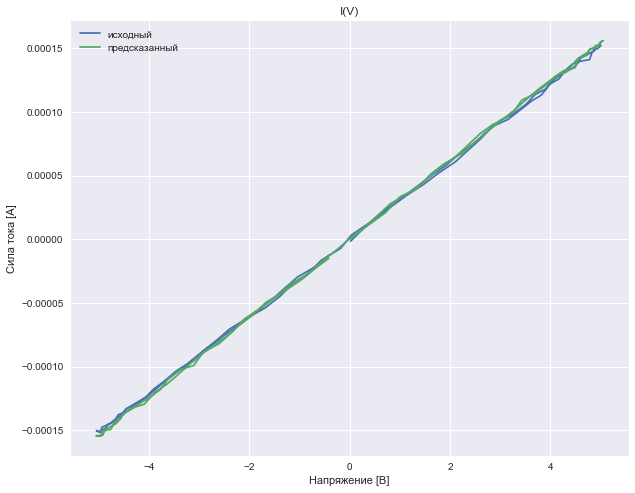

success: [53.10144701] -> 57.832848500116434 circuit C
SUCCESS:


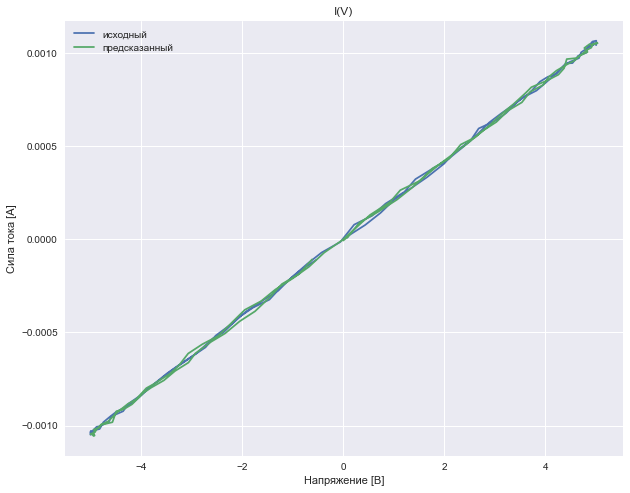

!!fail:  [46.58821552] -> [54.40543775 49.27734698] C detected like RC
FAIL:


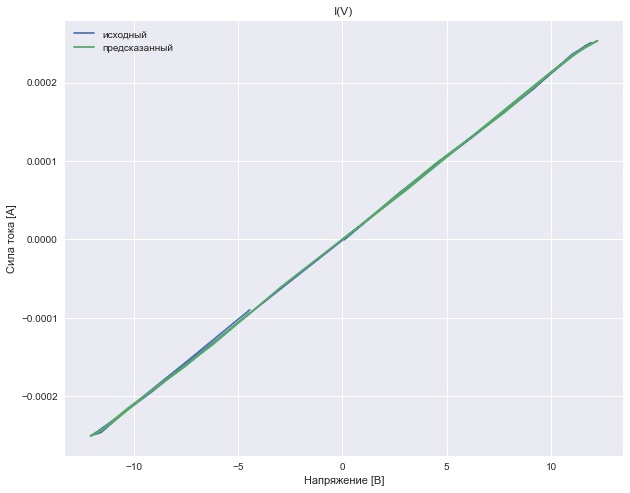

success: [43.07764252] -> 42.39495433304964 circuit D_R
SUCCESS:


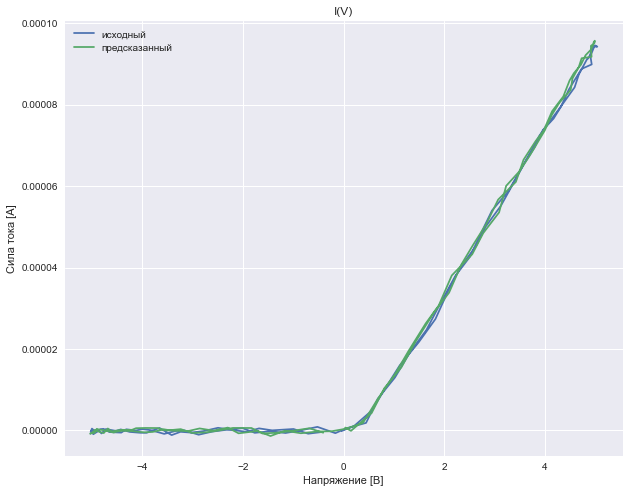

success: [74.17847766] -> 76.58019817488747 circuit DR
SUCCESS:


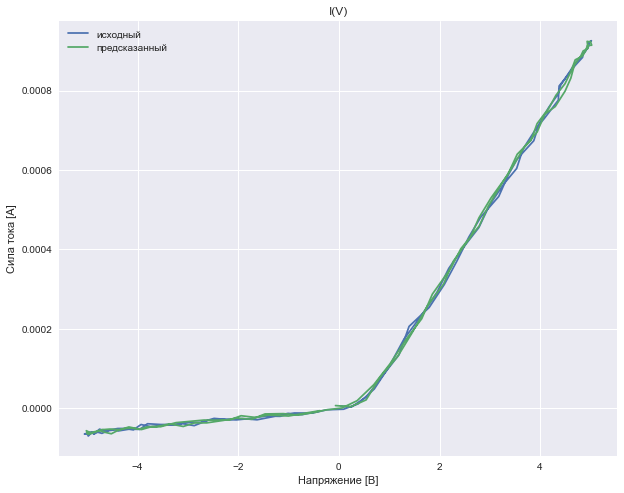

success: [15.23360916] -> 18.645403066997183 circuit D_R
SUCCESS:


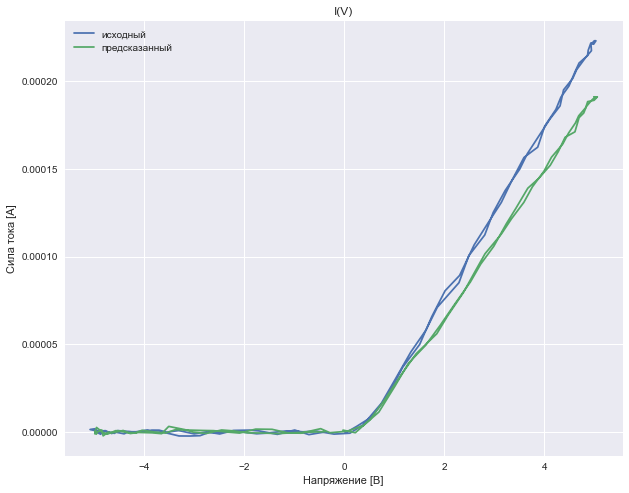

success: [42.196708] -> 43.76748461812928 circuit DR
SUCCESS:


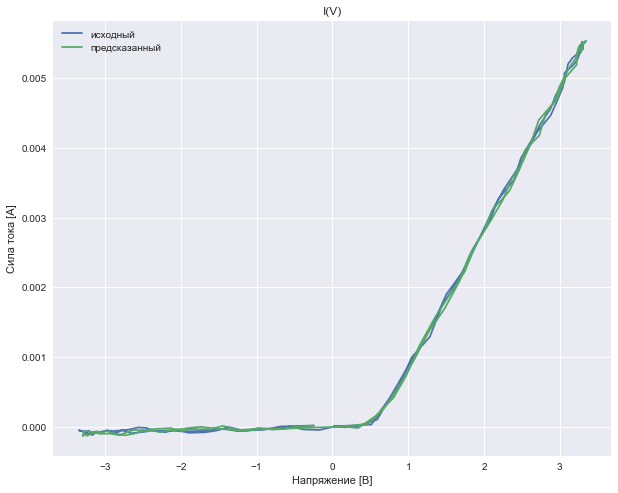

!!fail:  [7.3404058] -> [1.39063693 4.26296717] DR detected like DR_DR
FAIL:


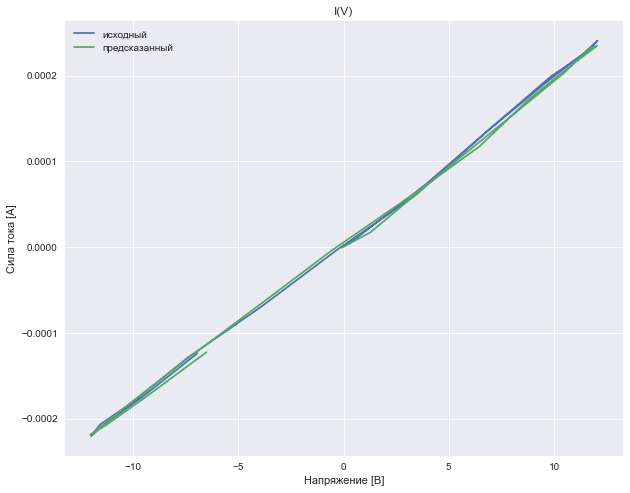

success: [97.94089366] -> 292.3708031490152 circuit L
SUCCESS:


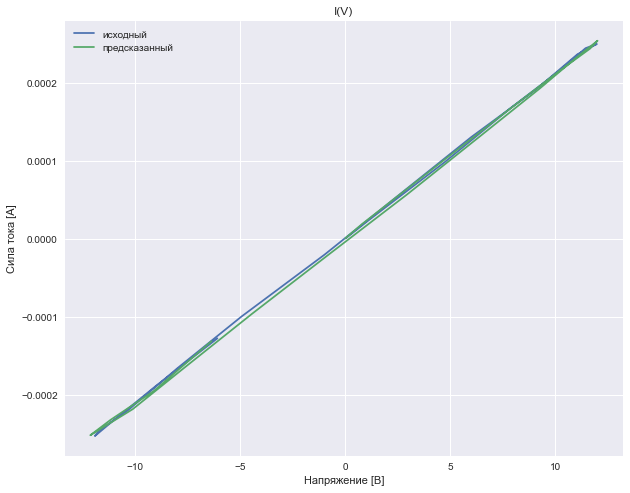

success: [13.07307403] -> 12.637160907969458 circuit DR
SUCCESS:


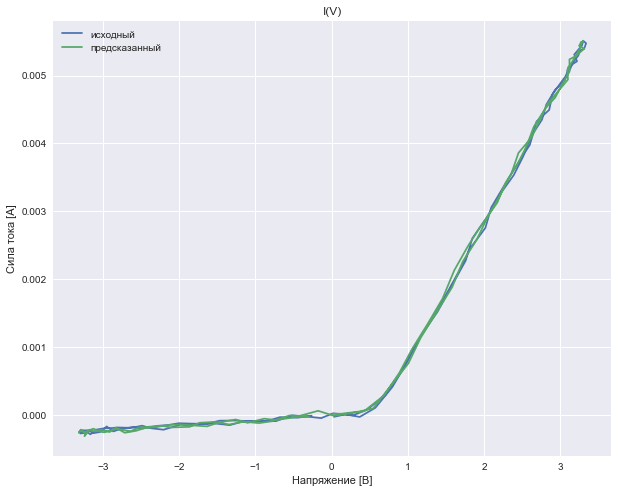

success: [7.76119073] -> 8.650554902586434 circuit R
SUCCESS:


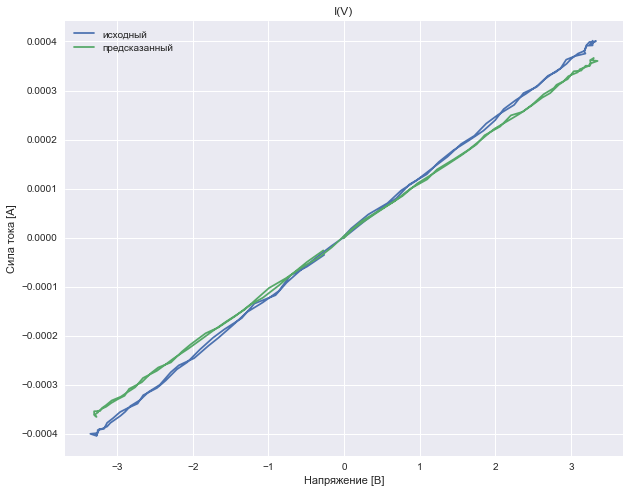

success: [55.36467827] -> 54.17586941597565 circuit DR
SUCCESS:


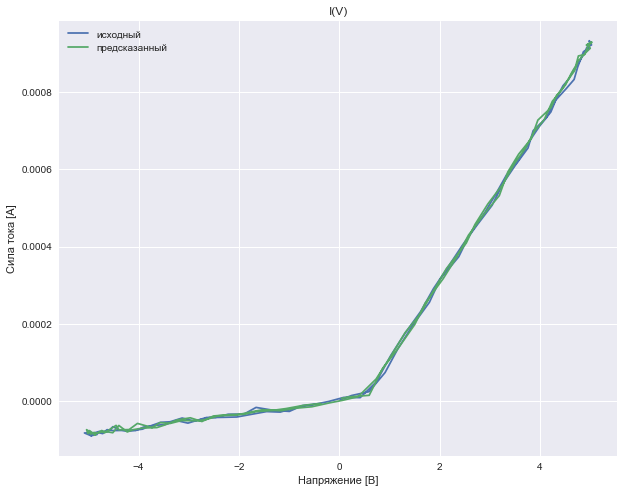

success: [55.3826656] -> 69.00992674778078 circuit DR
success: [55.68288398] -> 191.71178007473554 circuit L
success: [31.92392869] -> 33.60401458093458 circuit DR
success: [96.98887274] -> 95.71993016397089 circuit DR
success: [48.19183142] -> 48.581766730606695 circuit D_R
success: [6.42383324] -> 6.4193866200456835 circuit D_R
success: [95.12686092] -> 161.7332493029689 circuit L
success: [20.12520223] -> 21.7808813838696 circuit C
success: [73.67954796] -> 85.18855959760037 circuit DR
success: [34.3669925] -> 34.71700330290338 circuit R
success: [60.17423291] -> 62.81038037740079 circuit D_R
!!fail:  [63.99559202] -> [ 2.64887225 60.88866045] R detected like DR_R
FAIL:


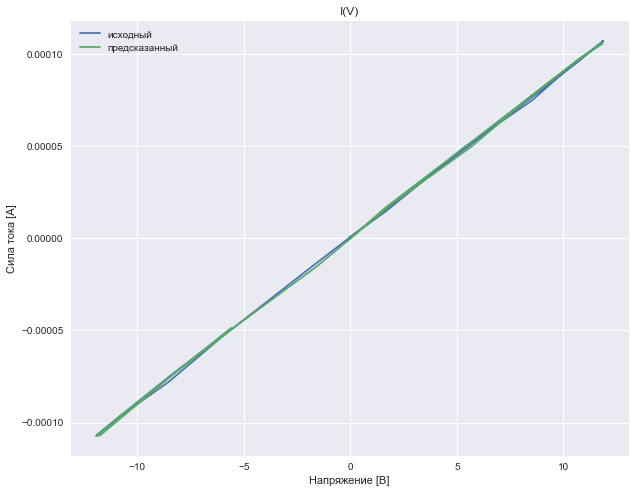

success: [6.15325332] -> 6.195090556093917 circuit DR
success: [41.61956] -> 218.4672095466184 circuit L
success: [46.42092474] -> 45.80202961272228 circuit D_R
success: [69.83619014] -> 169.4604317516745 circuit L
success: [60.56156026] -> 200.72699764809377 circuit L
success: [59.14895653] -> 65.66671123248531 circuit C
success: [11.18724321] -> 10.670644118120478 circuit C
!!fail:  [62.44597013] -> 24.58139834716563 L detected like C
FAIL:


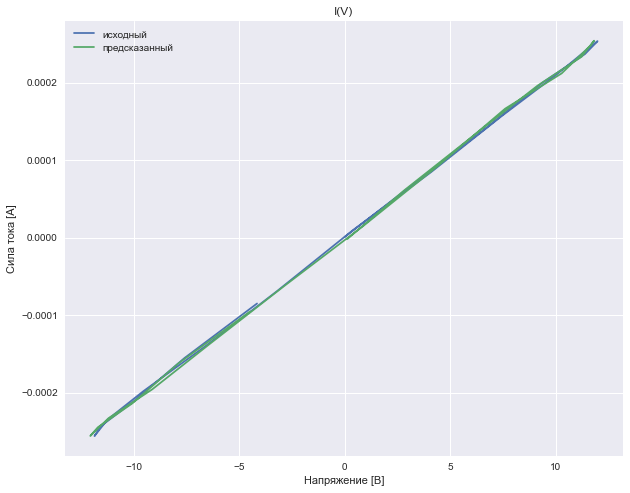

success: [79.8266884] -> 80.13569503546174 circuit D_R
!!fail:  [63.06790879] -> 35.69900143109053 L detected like C
FAIL:


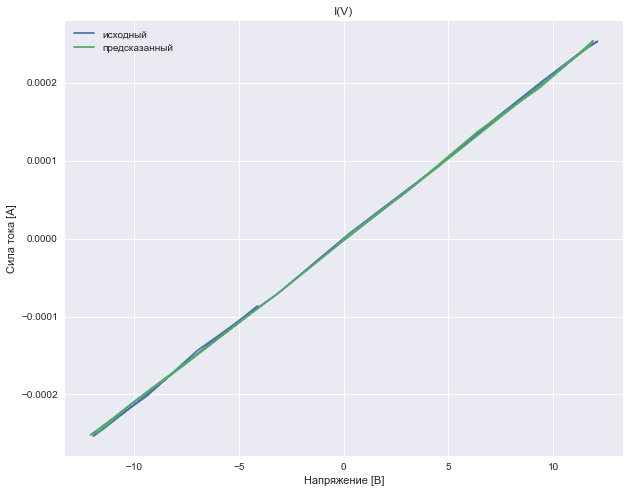

success: [36.85563156] -> 41.68643736444454 circuit DR
success: [51.91588598] -> 206.52095861524495 circuit L
success: [9.82769339] -> 11.005644113519118 circuit R
success: [44.33603265] -> 43.64618107779241 circuit D_R
success: [88.09291042] -> 88.82037689512057 circuit R
success: [68.6607237] -> 67.24618216121097 circuit D_R
success: [83.8032462] -> 83.09876402892274 circuit R
success: [79.22969619] -> 80.33872601421024 circuit R
success: [48.37270624] -> 153.46359239842354 circuit L
success: [68.985504] -> 283.36783738920354 circuit L
!!fail:  [80.61855938] -> [53.23212939 55.95375466  1.1369829 ] L detected like DR_DR_R
FAIL:


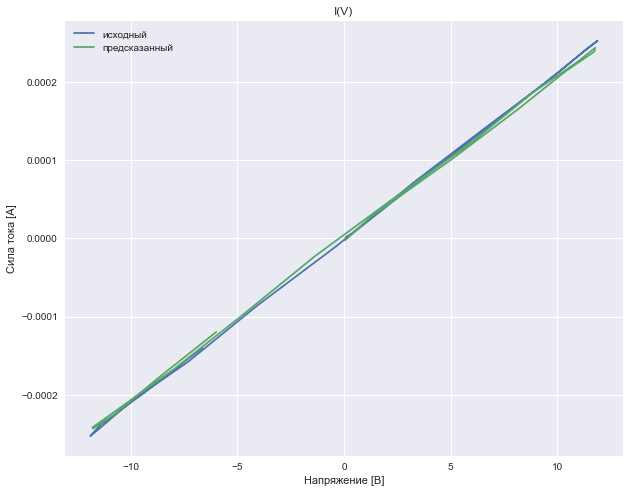

success: [69.71562279] -> 69.35516950391082 circuit R
success: [9.80431495] -> 9.567830290322286 circuit C
success: [73.43946057] -> 70.91684983328258 circuit DR
!!fail:  [55.97990738] -> [53.48060771 48.95409905] L detected like RC
FAIL:


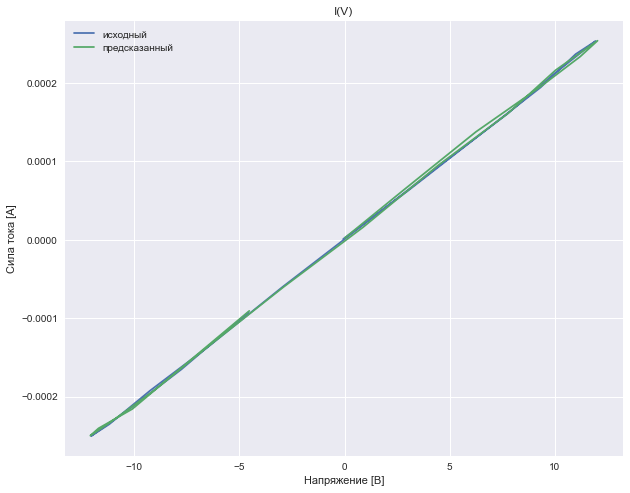

success: [16.10862413] -> 16.28836519185708 circuit C

SUCCESS: 43, FAIL: 7 of 50 tests
RANK2 CIRCUIT TESTING ..
success: [92.18870476 92.9724403 ] -> [92.77606477 93.86685255] circuit DR_R
SUCCESS:


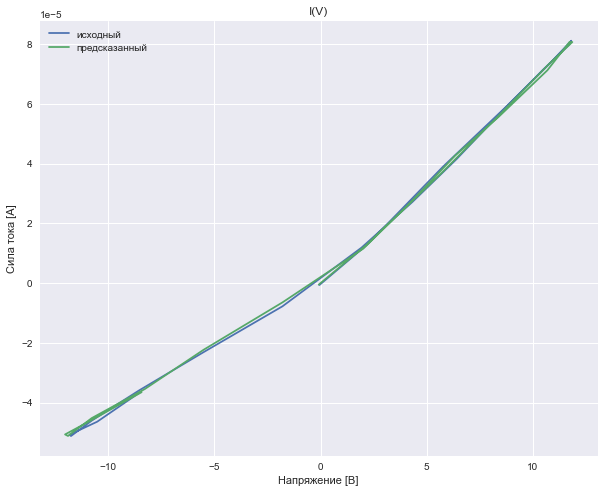

success: [23.18409303 15.01042808] -> [55.03122024 57.19369052] circuit RC
SUCCESS:


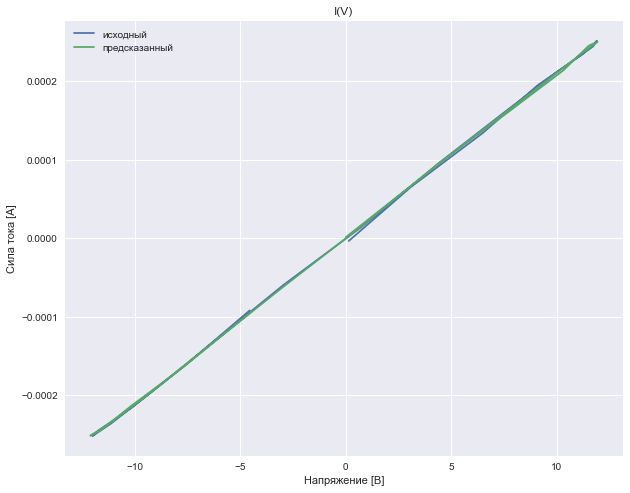

success: [75.60959369 53.43714642] -> [82.30819703 53.52739994] circuit DR_R
SUCCESS:


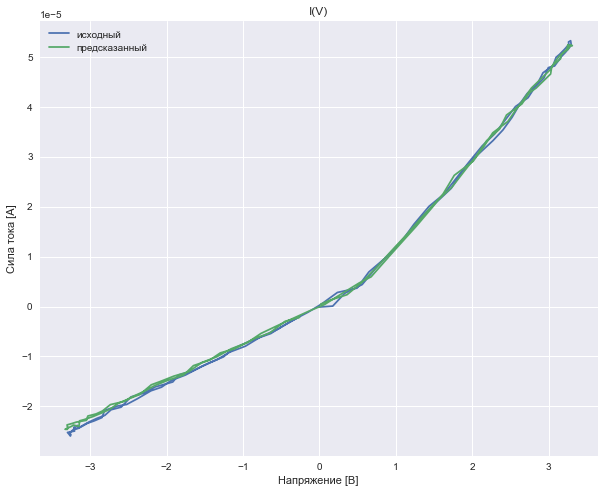

success: [79.91722383 85.98443143] -> [77.30050474 85.69085963] circuit RC
SUCCESS:


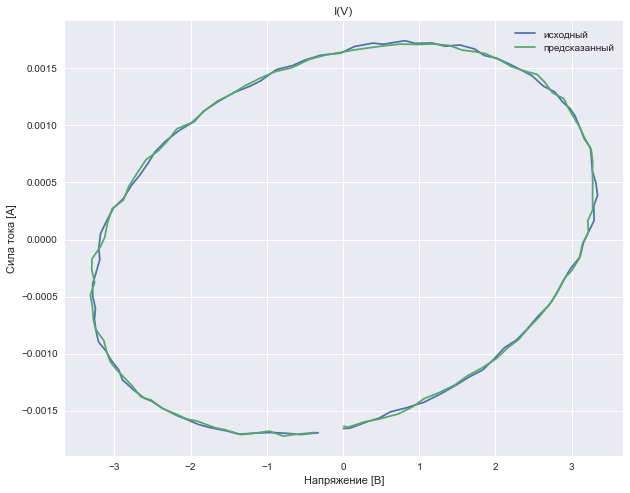

success: [87.16519715 37.03521928] -> [87.14687922 37.61296127] circuit DR_DR
SUCCESS:


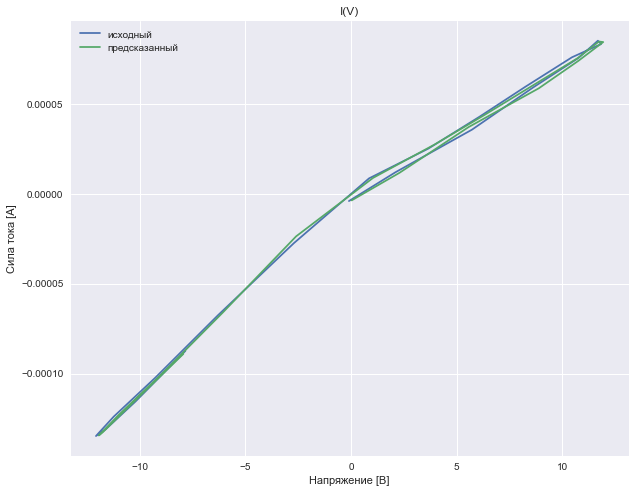

!!fail:  [ 4.6149935  93.16857799] -> [ 5.69559905 11.59055949] R_C detected like RC
FAIL:


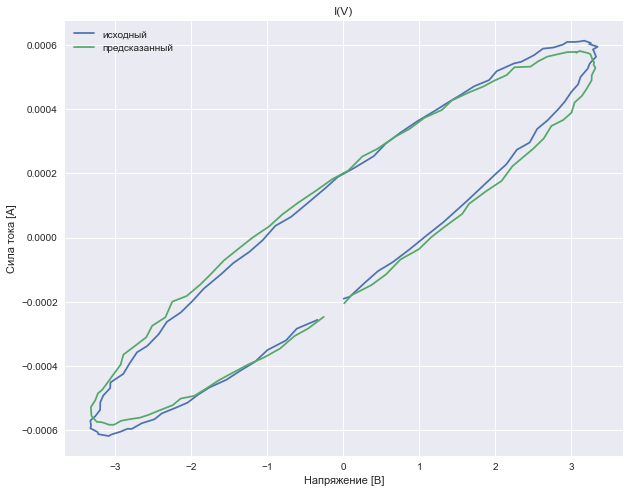

success: [76.41773864 54.14097927] -> [82.45368543 54.69923766] circuit DR_R
SUCCESS:


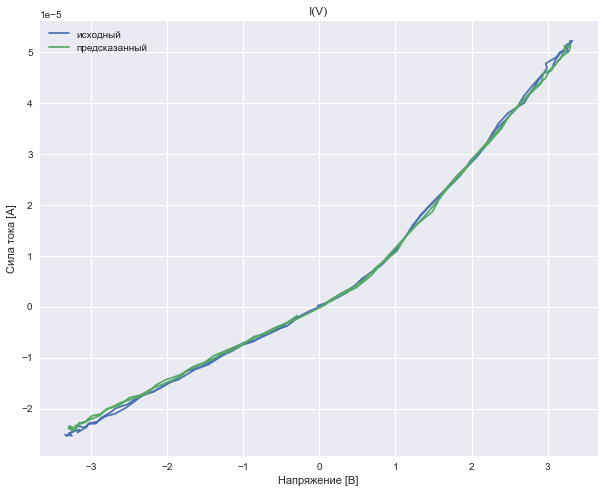

success: [64.92620591 67.3431556 ] -> [69.94941784 67.23685727] circuit DR_R
SUCCESS:


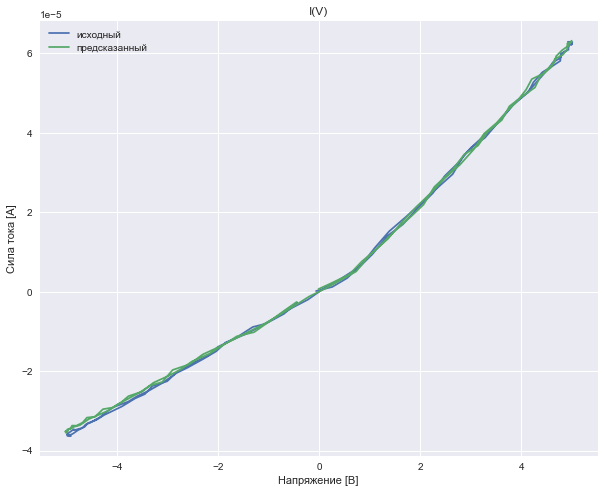

success: [29.074025   26.18149519] -> [28.37575402 26.33548034] circuit DR_DR
SUCCESS:


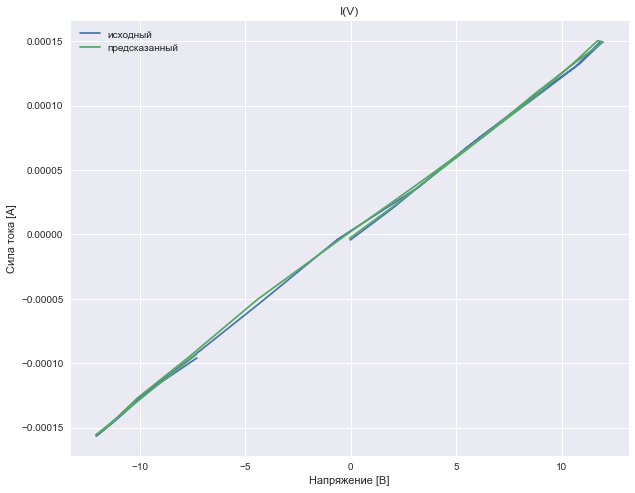

success: [58.66006347 21.44552703] -> [58.84841812 21.85633331] circuit DR_DR
SUCCESS:


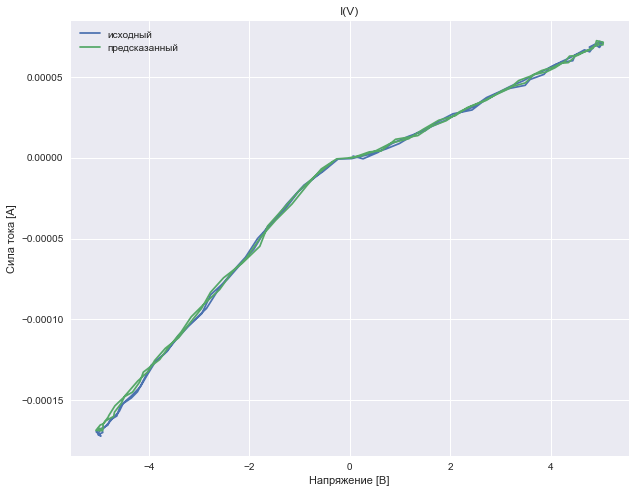

success: [12.82520156 50.68566733] -> [14.32163754 51.65671135] circuit DR_R
SUCCESS:


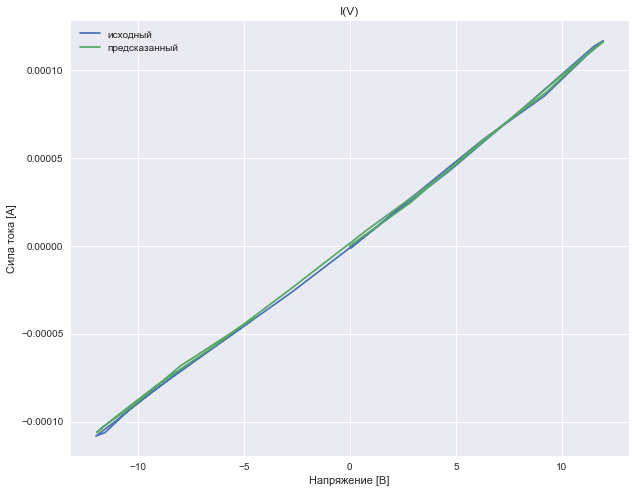

success: [99.46405944 63.93014975] -> [91.12631136 65.14912476] circuit DR_R
success: [22.57043574 78.6445015 ] -> [22.61938879 79.06289932] circuit DR_DR
!!fail:  [45.31921893 24.0339341 ] -> 29.455314725882154 RC detected like C
FAIL:


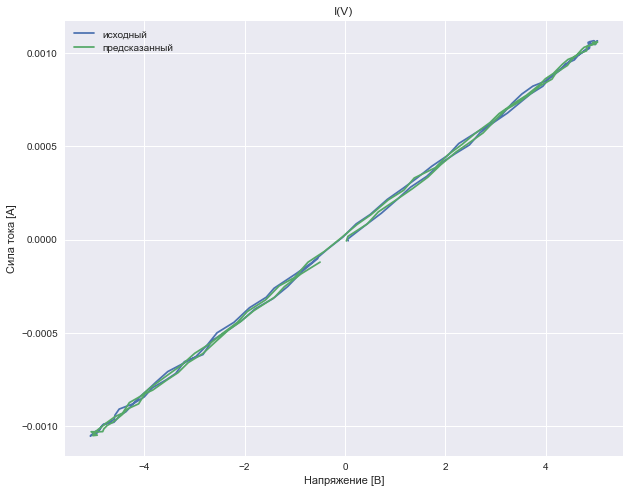

!!fail:  [26.20296217 37.11683192] -> [26.64007993  0.89457524] R_C detected like RC
FAIL:


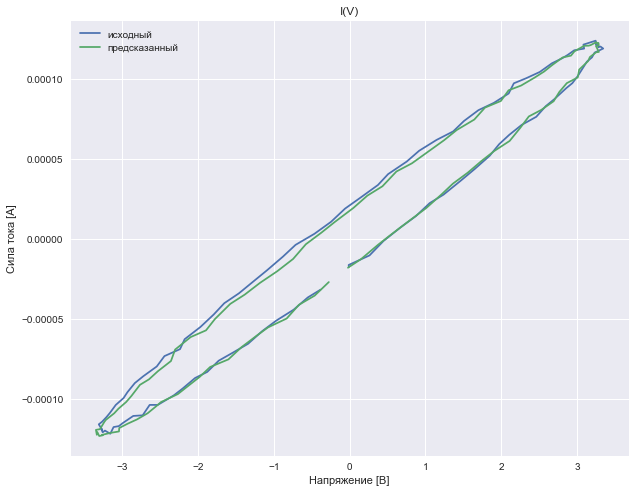

success: [53.09328262 39.837558  ] -> [53.41726554 48.21312356] circuit R_C
success: [72.87380662 31.93732417] -> [72.44902143 56.54146529] circuit R_C
!!fail:  [64.21598661  1.73092527] -> [43.36860957  5.15143432] RC detected like R_C
FAIL:


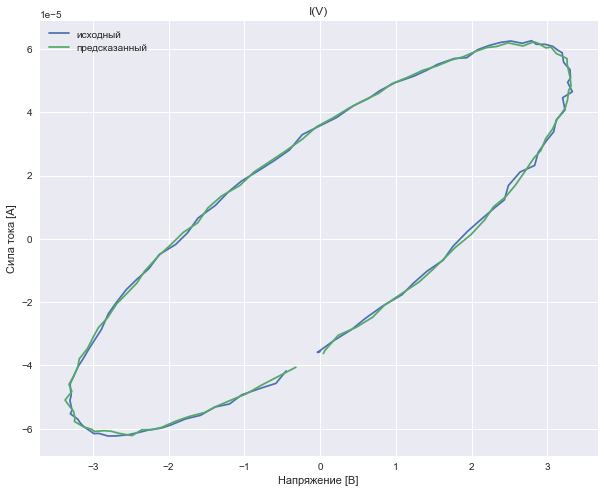

success: [64.3868995  71.24281603] -> [65.06817008 71.81298081] circuit DR_DR
success: [93.21150251 93.38077923] -> [93.37038314 93.65903036] circuit DR_DR
!!fail:  [50.52759184 75.06519054] -> 70.5493875799352 RC detected like C
FAIL:


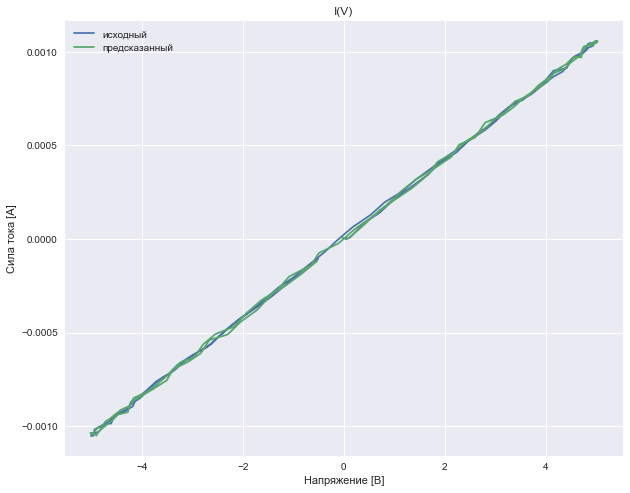

success: [84.41709664  1.242312  ] -> [86.38922221  1.30755346] circuit DR_DR
success: [19.30637866 73.67977476] -> [24.49253737 74.7378735 ] circuit RC
success: [96.17240797 20.19415541] -> [96.0927267  42.46960468] circuit R_C
success: [78.12702046 34.07319954] -> [78.38865984 31.32995323] circuit R_C
success: [41.48626623 59.36894124] -> [55.92165029 65.08464519] circuit RC
success: [ 0.36371958 17.69628494] -> [ 0.61556635 29.29508649] circuit R_C
success: [21.5450095  85.33719854] -> [21.44944969 84.03831995] circuit DR_DR
success: [14.08015082 28.53545754] -> [13.21524973 28.16393734] circuit DR_R
success: [76.70571155 24.36570105] -> [78.73977831 24.35061559] circuit DR_R
success: [74.5938871  85.77858618] -> [74.61054783 89.54863568] circuit R_C
!!fail:  [ 9.81159227 86.6992123 ] -> [9.46933969 2.44090856] R_C detected like RC
FAIL:


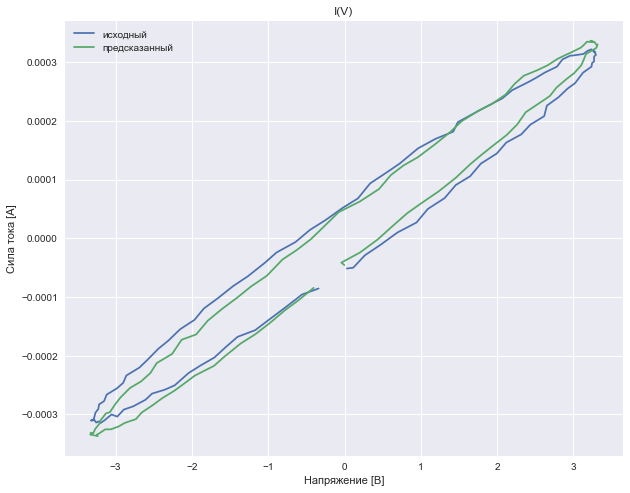

success: [41.76878153 14.98631251] -> [38.18375845 14.82757437] circuit DR_R
success: [13.93001308 44.5183486 ] -> [14.07522111 44.02894463] circuit DR_DR
success: [24.44499945 94.71211879] -> [22.14355594 96.32204607] circuit DR_R
!!fail:  [44.89449132 13.36589368] -> [13.01252433 47.20099147] DR_R detected like DR_DR
FAIL:


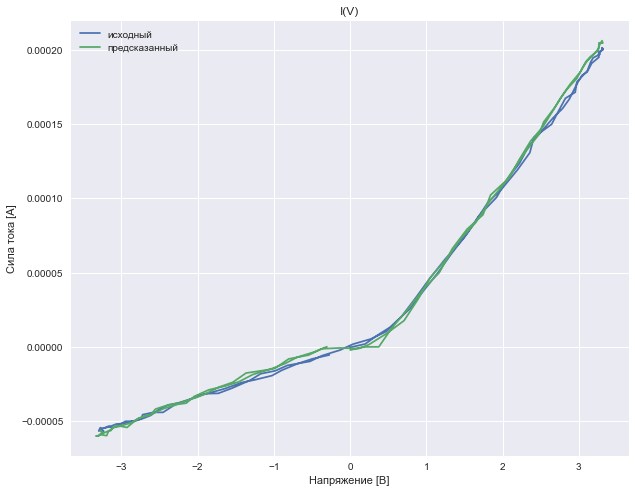

success: [88.26294017 75.2503281 ] -> [87.93131306 74.86468621] circuit DR_DR
success: [99.7684113 15.3854209] -> [97.67728879 15.01129112] circuit DR_DR
success: [99.11965475 15.64991706] -> [99.11945735 43.07906268] circuit R_C
!!fail:  [14.88625903 15.36112801] -> 38.39255048916686 RC detected like C
FAIL:


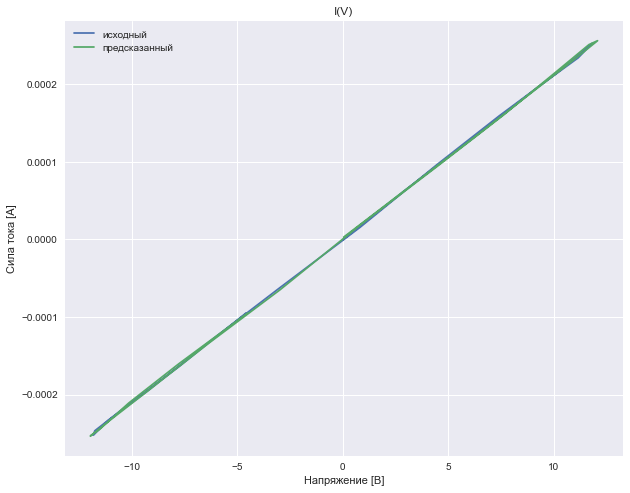

success: [88.48904618 24.99764072] -> [88.26978156 41.84935541] circuit R_C
!!fail:  [ 8.14151734 52.8396589 ] -> 36.49836967266147 RC detected like C
FAIL:


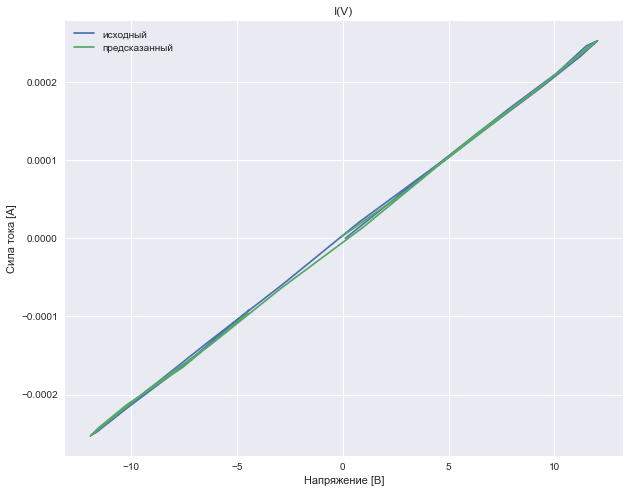

success: [74.42385697 35.33392438] -> [76.02906678 35.55902176] circuit DR_R
success: [ 7.20060638 85.80992923] -> [ 6.57157877 85.98218871] circuit RC
!!fail:  [0.75252905 1.42641397] -> [61.23784178 65.09768987  2.18773504] DR_R detected like DR_DR_R
FAIL:


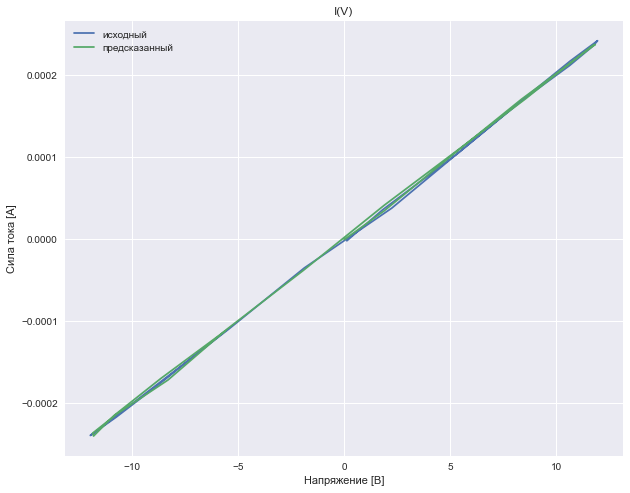

success: [10.31156131 58.22153695] -> [10.71782796 54.74228772] circuit R_C
success: [31.27922638 39.30729974] -> [31.27220737 25.85286316] circuit R_C
success: [16.63892183 22.43219133] -> [16.00770412 20.4126753 ] circuit R_C
success: [76.68517662 69.13731676] -> [76.78065083 69.28260393] circuit DR_DR
success: [63.44793265 30.81149705] -> [61.95292323 30.70892599] circuit DR_DR

SUCCESS: 40, FAIL: 10 of 50 tests
RANK3 CIRCUIT TESTING ..
!!fail:  [32.04950635 30.6717908  97.7698081 ] -> [23.07795895 21.71285847] DR_DR_R detected like DR_DR
FAIL:


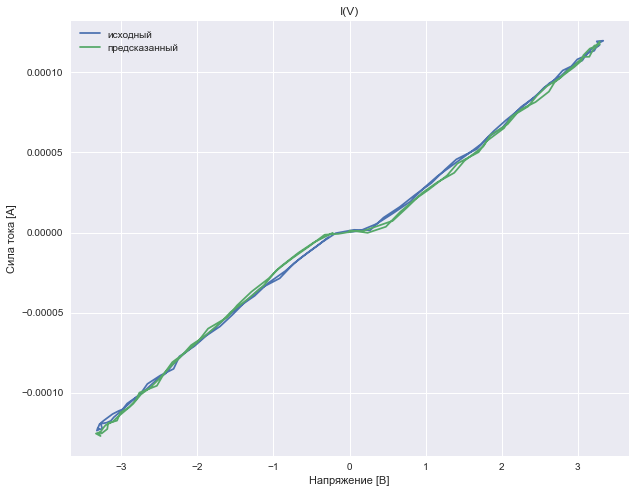

!!fail:  [28.45164376 62.13829932 77.69645809] -> [19.3120698  32.47807472] DR_DR_R detected like DR_DR
FAIL:


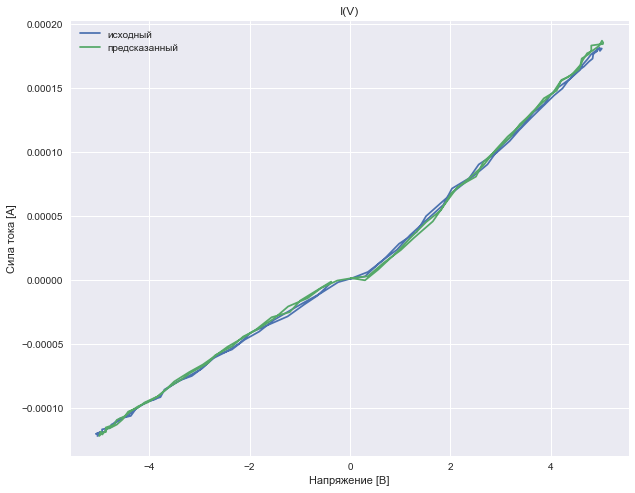

!!fail:  [38.7633369  39.9527254  97.41233782] -> [25.76696187 26.87012059] DR_DR_R detected like DR_DR
FAIL:


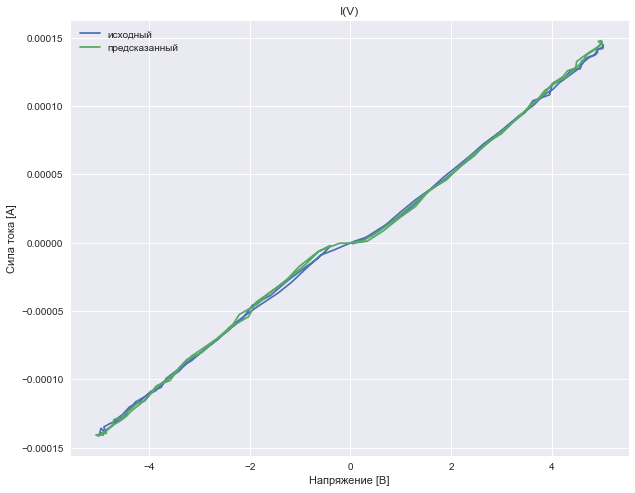

success: [92.71078808 96.39859879 61.15990544] -> [72.73038867 74.56116682 77.41833617] circuit DR_DR_R
SUCCESS:


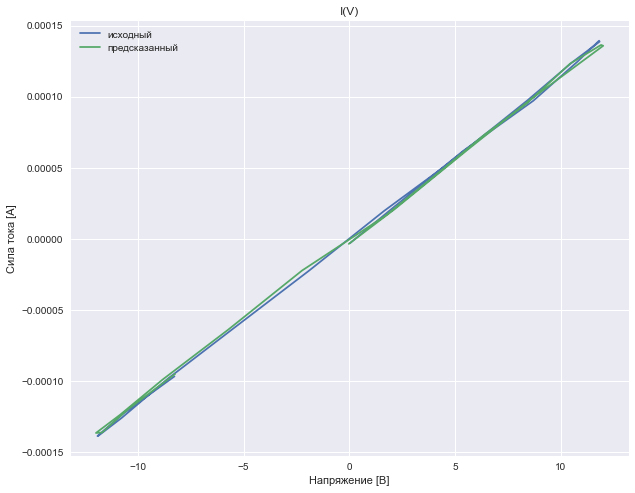

success: [20.12434197 76.02864144  5.97593091] -> [27.6164986  61.58539548  5.9905783 ] circuit DR_DR_R
SUCCESS:


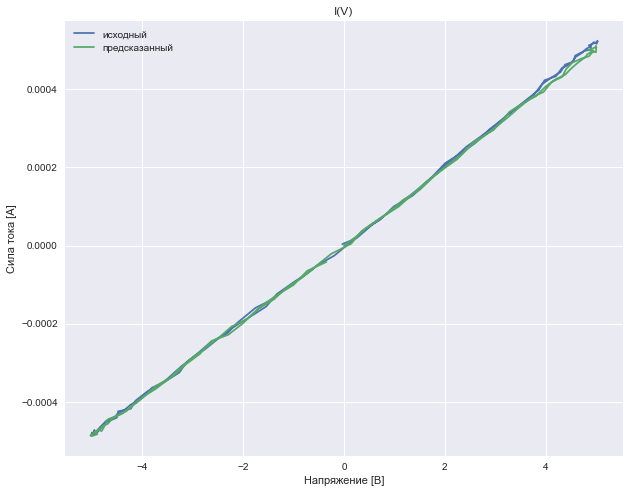

success: [94.83913685 58.09415537 72.1322987 ] -> [89.23304165 58.47235876 77.17500156] circuit DR_DR_R
SUCCESS:


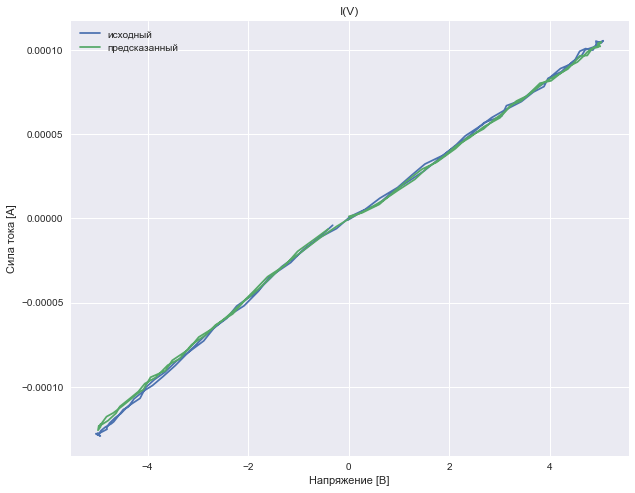

!!fail:  [43.46905943  1.29183933 53.1737988 ] -> [21.12722134  1.28476524] DR_DR_R detected like DR_DR
FAIL:


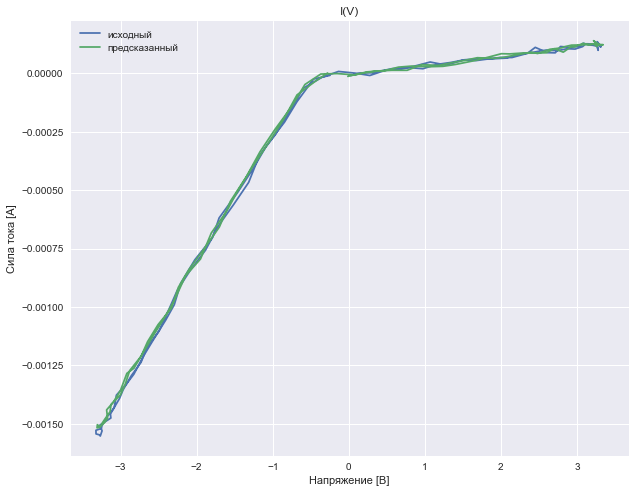

!!fail:  [20.71801208 89.55829952 77.05253545] -> [15.43268598 36.91737235] DR_DR_R detected like DR_DR
FAIL:


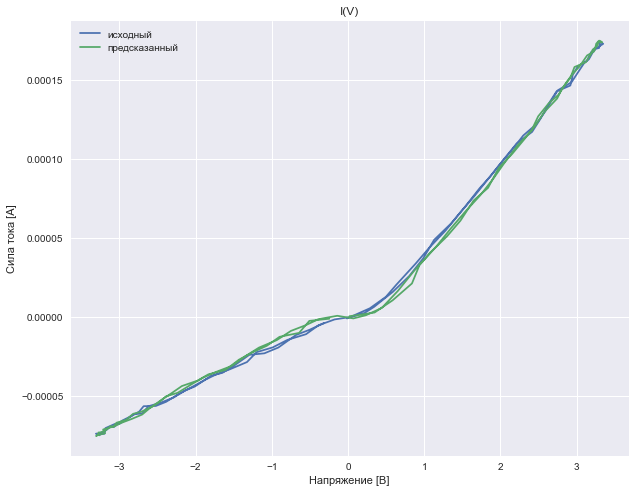

!!fail:  [22.35443179 14.5319638   1.82912735] -> 1.6476198855762323 DR_DR_R detected like R
FAIL:


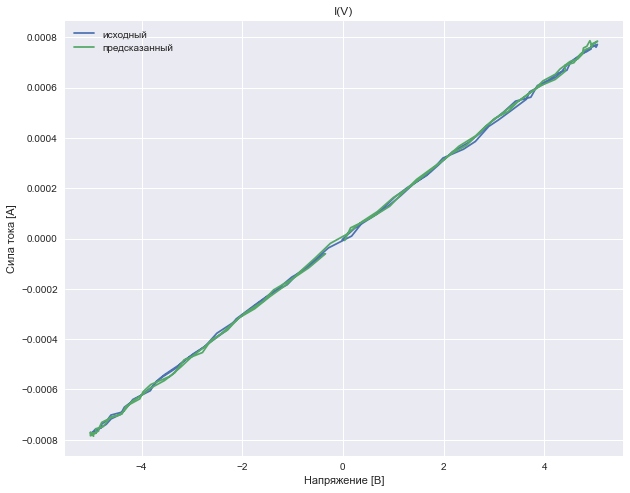

!!fail:  [33.68412226 42.52676605 83.56326585] -> [22.49759538 26.76150533] DR_DR_R detected like DR_DR
FAIL:


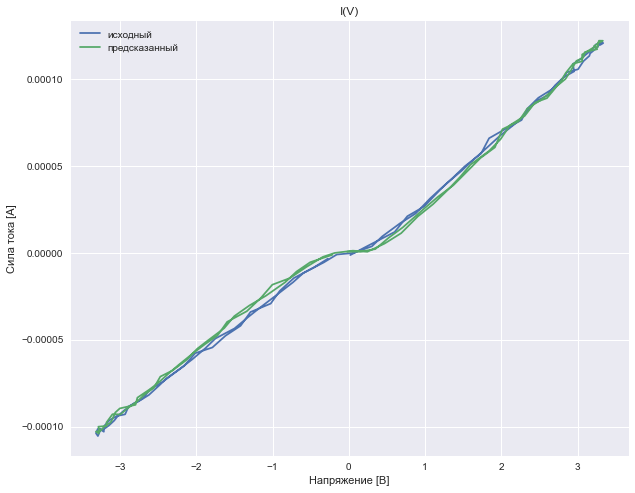

!!fail:  [47.0975673  66.19066171 88.14080869] -> [28.34633557 35.17726724] DR_DR_R detected like DR_DR
FAIL:


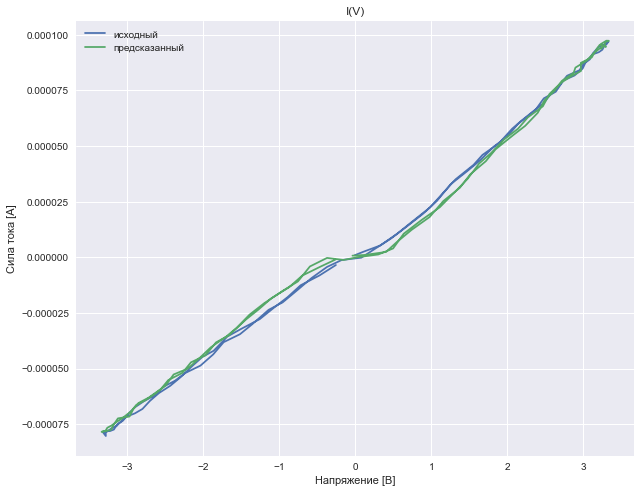

!!fail:  [16.94796669 41.92538859 82.4174796 ] -> [22.90193836 49.74581501] DR_DR_R detected like R_C
FAIL:


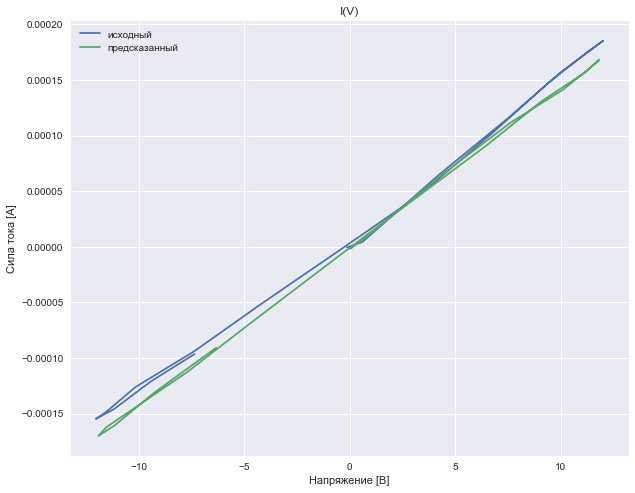

!!fail:  [29.48338456 20.73859948 18.80657182] -> [9.98809018 8.93824175] DR_DR_R detected like DR_DR
FAIL:


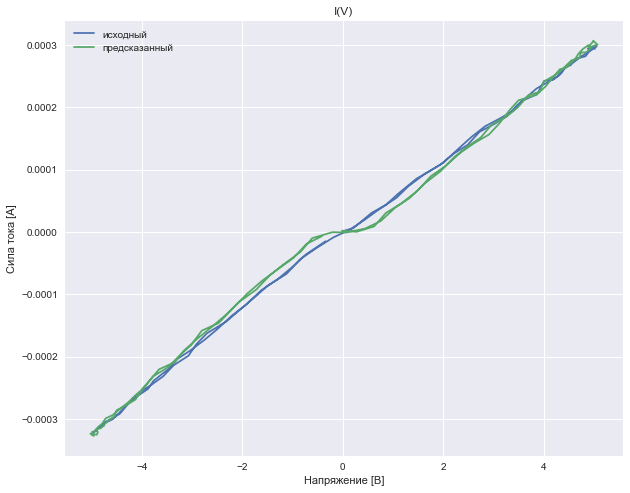

success: [ 4.75226667  7.16211672 30.53740965] -> [19.91935529 39.0453509  14.42376482] circuit DR_DR_R
SUCCESS:


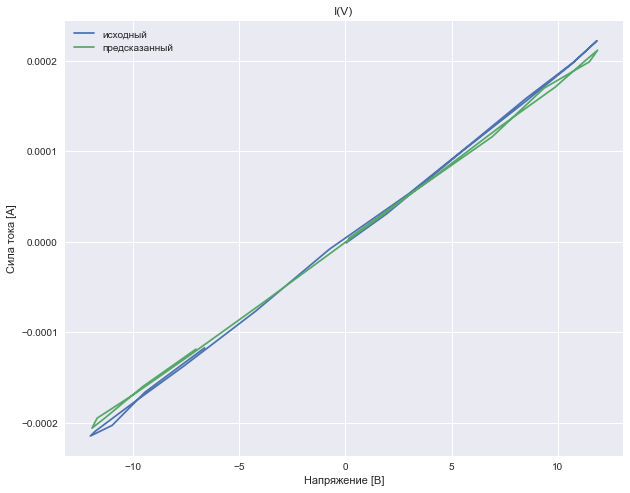

success: [30.89110884 68.44612456 75.99122605] -> [29.37079426 65.17124366 81.47062377] circuit DR_DR_R
SUCCESS:


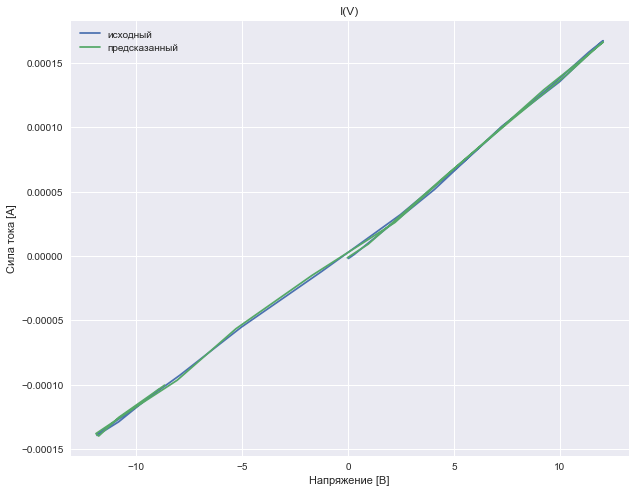

success: [42.39575696 80.12290434 81.46429485] -> [45.18548962 83.51053432 81.07760246] circuit DR_DR_R
SUCCESS:


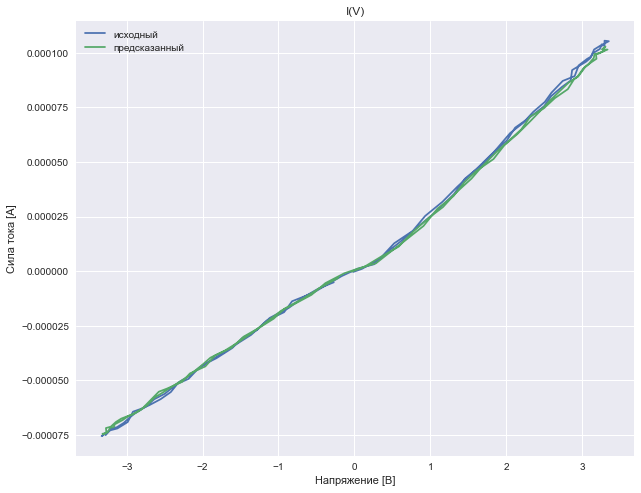

!!fail:  [80.57787534 98.66449038  0.9961162 ] -> 1.0515534262786776 DR_DR_R detected like R
FAIL:


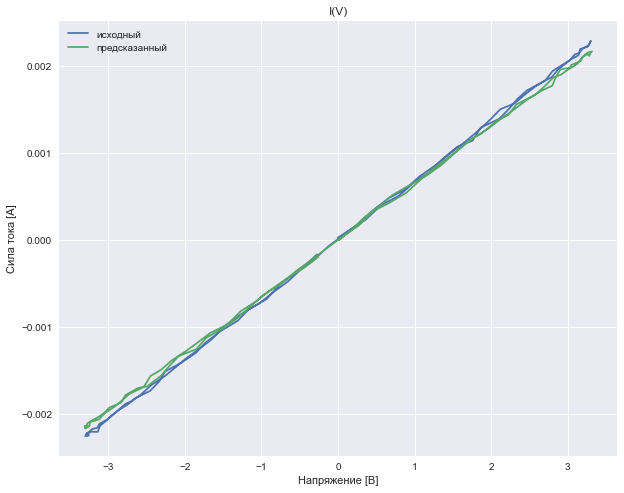

!!fail:  [34.17085279 16.84726638 10.01417264] -> [6.44606942 4.8010762 ] DR_DR_R detected like DR_DR
FAIL:


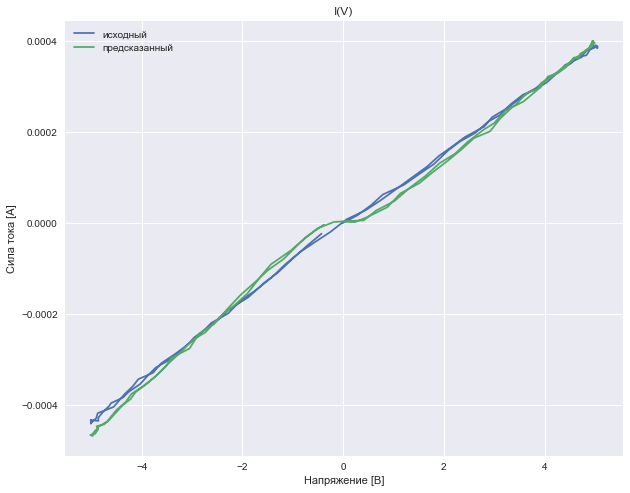

!!fail:  [12.76779703 24.49585449 87.99886782] -> [11.03172273 17.86950499] DR_DR_R detected like DR_DR
FAIL:


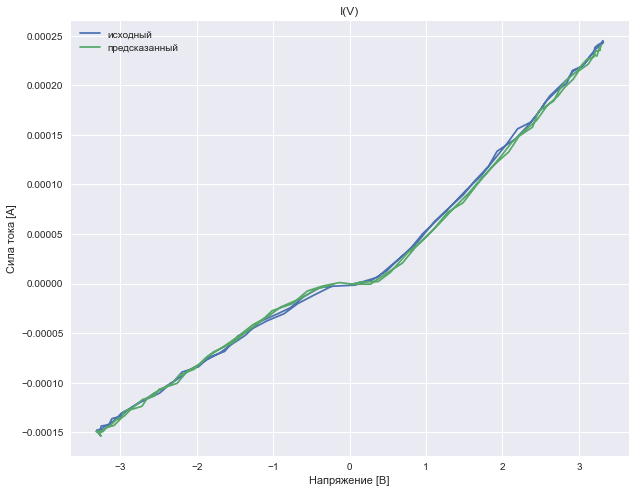

!!fail:  [84.35993895 72.73378982 14.80834962] -> [-0.62709731 12.18046061] DR_DR_R detected like DR_R
FAIL:


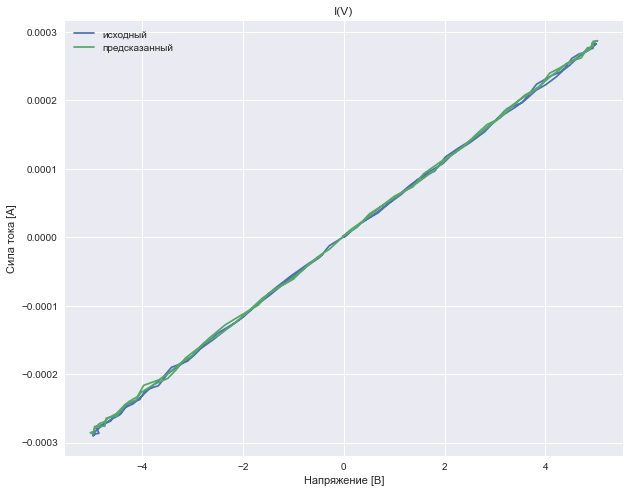

success: [64.86947977 53.78261056 43.08721088] -> [67.90077895 52.04803258 42.67745877] circuit DR_DR_R
SUCCESS:


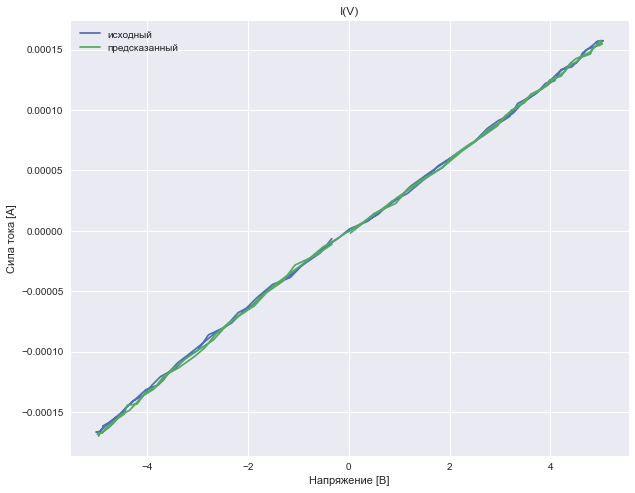

!!fail:  [ 3.8011763  13.59476019 52.94749108] -> [ 3.52293241 10.06056934] DR_DR_R detected like DR_DR
FAIL:


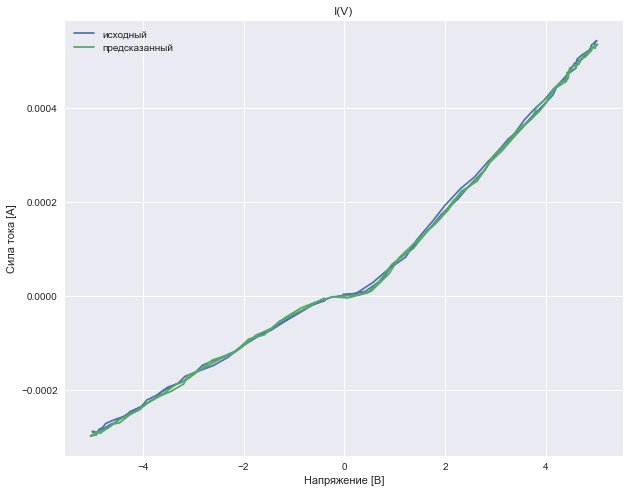

!!fail:  [40.71450908 97.99946589 67.90069285] -> [23.66728089 37.59249999] DR_DR_R detected like DR_DR
FAIL:


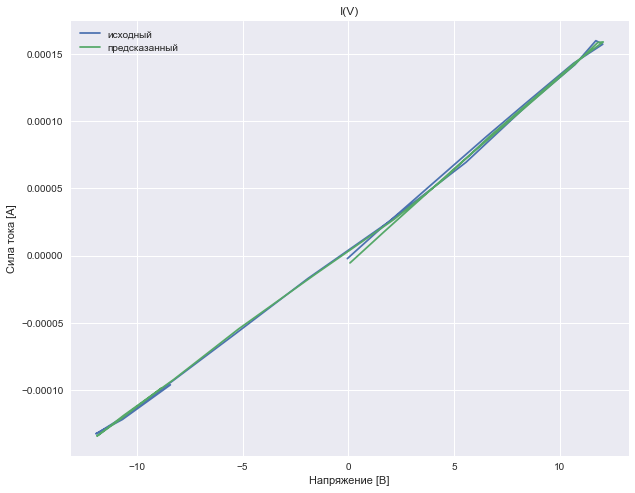

!!fail:  [13.86715577  2.22054185 25.68684566] -> [6.48582001 1.94929149] DR_DR_R detected like DR_DR
FAIL:


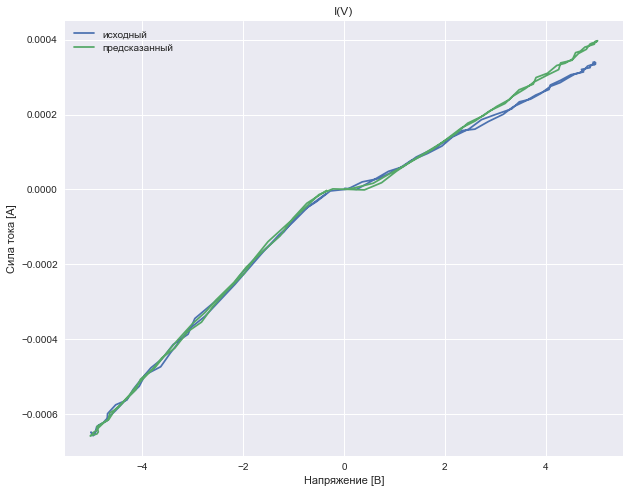

success: [79.62931274 39.81776509 31.10957133] -> [76.35426763 47.07038601 30.43610805] circuit DR_DR_R
SUCCESS:


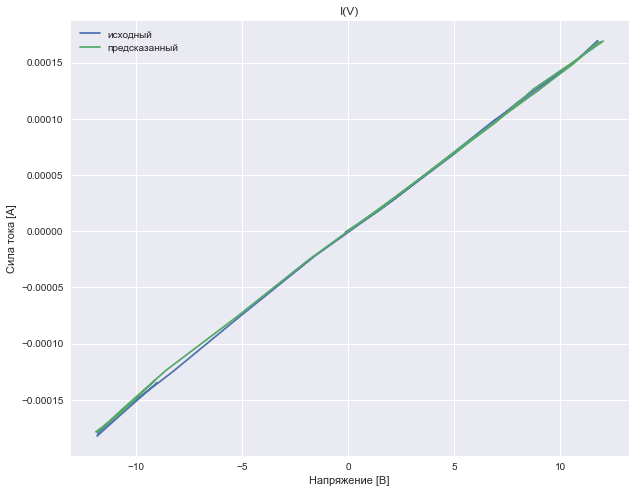

!!fail:  [27.45273476 21.64871091 72.84673121] -> [18.67020162 15.61076218] DR_DR_R detected like DR_DR
FAIL:


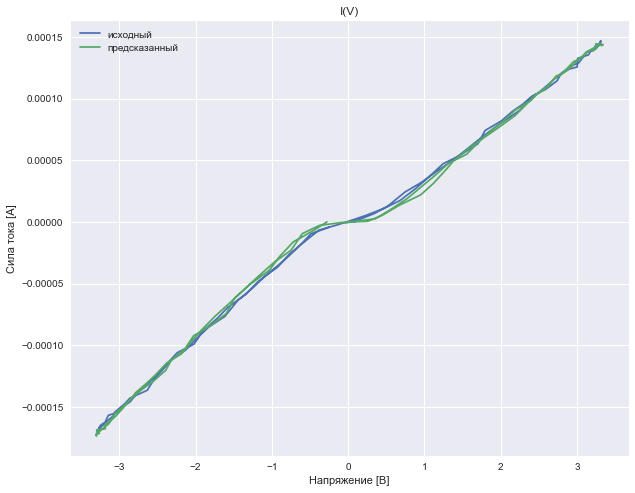

!!fail:  [10.53626422  7.69136211 66.0209506 ] -> [8.79577005 6.94777148] DR_DR_R detected like DR_DR
FAIL:


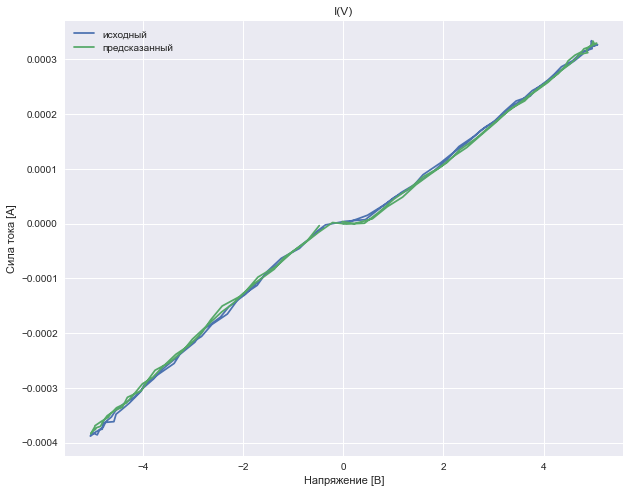

!!fail:  [36.20247034 37.73873318 27.90052583] -> [17.92564585 59.22629595] DR_DR_R detected like R_C
FAIL:


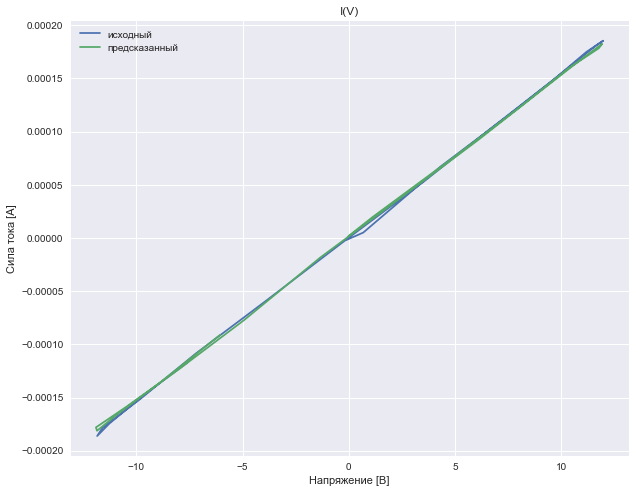

!!fail:  [ 9.0885409  57.51852436 49.89292554] -> [ 6.70050269 24.50235118] DR_DR_R detected like DR_DR
!!fail:  [87.6580066  34.13045302 67.86506715] -> [34.7312067  20.78042417] DR_DR_R detected like DR_DR
!!fail:  [30.30476033 71.98965634 48.82990909] -> [18.11914342 26.1207988 ] DR_DR_R detected like DR_DR
success: [24.03318983 91.06922428 10.92212213] -> [23.38628442 70.41695841 10.13036592] circuit DR_DR_R
SUCCESS:


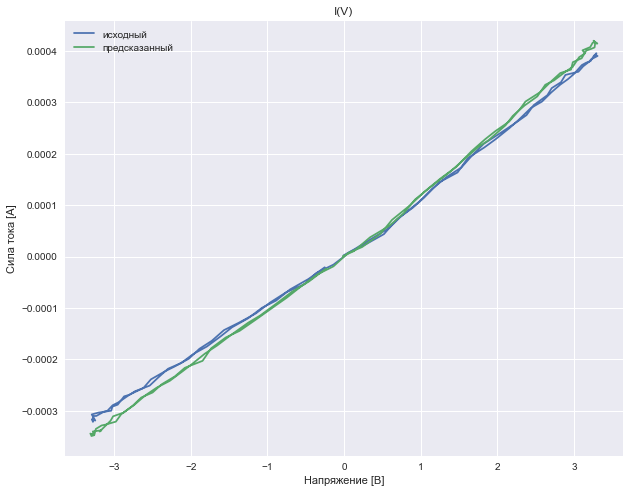

!!fail:  [15.60195347 52.87538176  3.40502177] -> 3.937962099275973 DR_DR_R detected like DR
success: [52.18465742 14.24530568  7.98612205] -> [47.26901276 16.00124569  7.82541373] circuit DR_DR_R
SUCCESS:


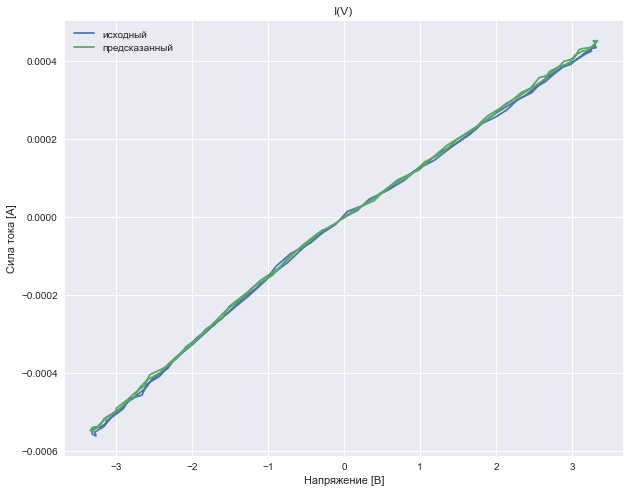

success: [37.95233175 81.88818312 89.78992823] -> [33.53466594 81.54031729 84.83667102] circuit DR_DR_R
success: [96.65180592 75.04147273 28.60498575] -> [77.88924207 75.02728448 29.67815134] circuit DR_DR_R
success: [91.32838186 12.76330016 19.69097784] -> [75.24050119 15.79443008 23.48057302] circuit DR_DR_R
!!fail:  [31.41996312  3.7994881  52.45716025] -> [18.23687095  3.50697483] DR_DR_R detected like DR_DR
!!fail:  [64.4283638  38.14347806  5.40041345] -> 4.873532325986463 DR_DR_R detected like R
!!fail:  [ 5.78652925 53.14175678 27.71910326] -> [ 4.55981072 16.20610646] DR_DR_R detected like DR_DR
!!fail:  [60.27850974 30.19592061 45.95720633] -> [23.48983755 16.36447047] DR_DR_R detected like DR_DR
!!fail:  [10.74969259 72.66066252 15.94706709] -> [ 5.76266317 10.24741921] DR_DR_R detected like DR_DR
!!fail:  [16.2353362  13.77325189 94.30204302] -> [16.00886404 48.31543579] DR_DR_R detected like R_C
!!fail:  [29.24974652 35.64177008 48.96403522] -> [17.41628632 18.78067018] DR

In [17]:
%%time
cre.test_me()

### Тесты на реальных приборных Данных

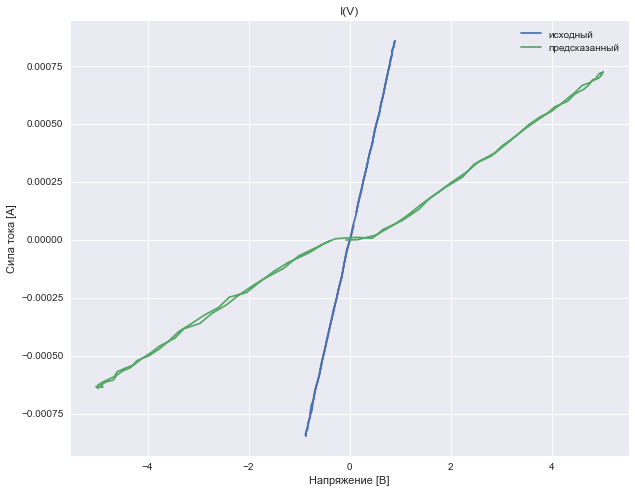

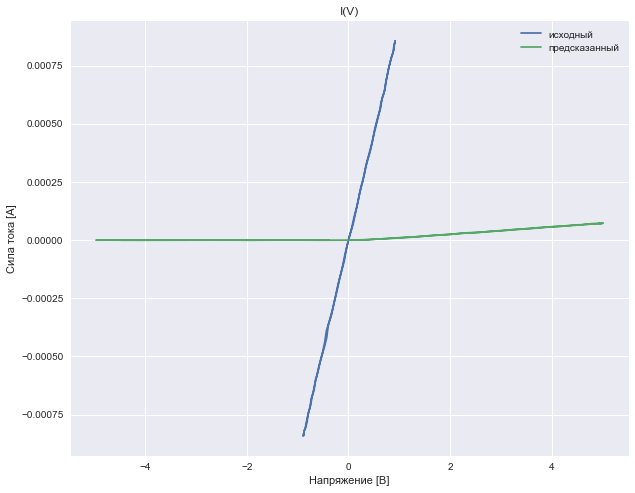

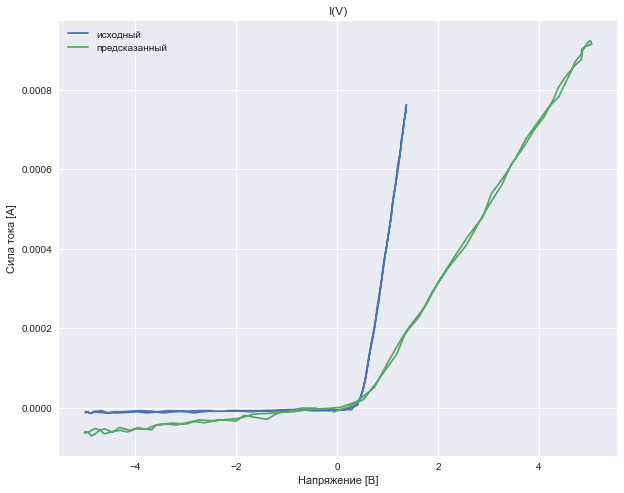

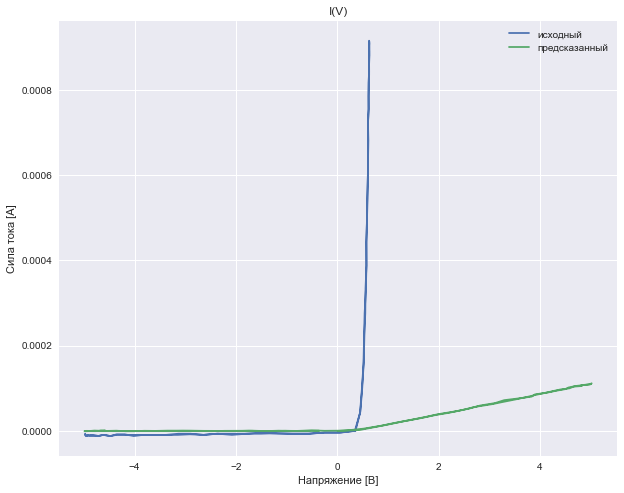

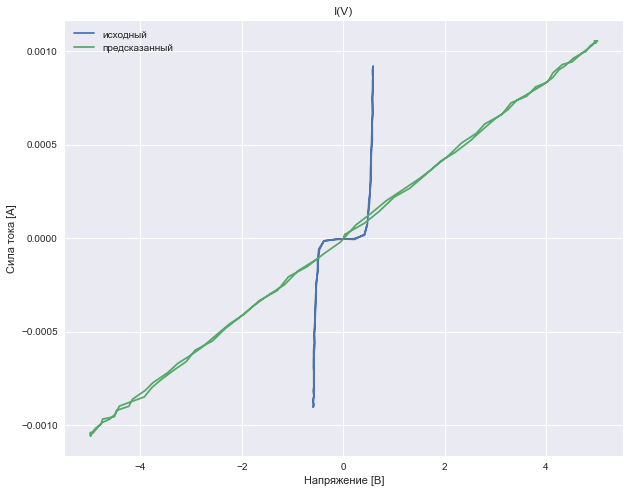

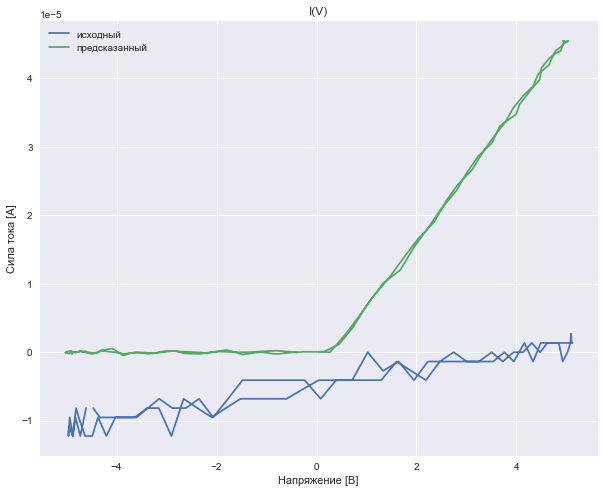

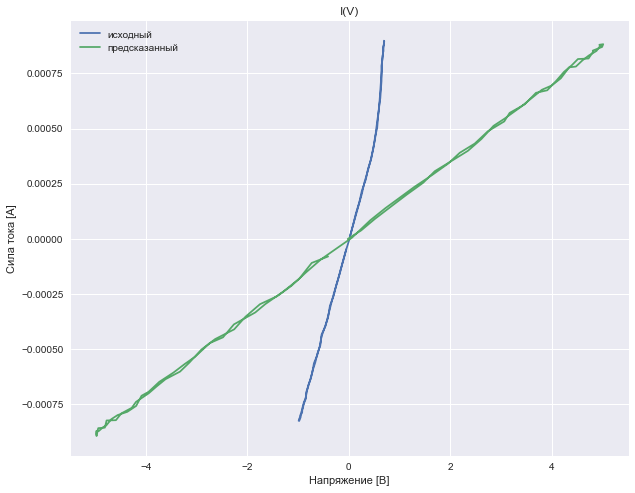

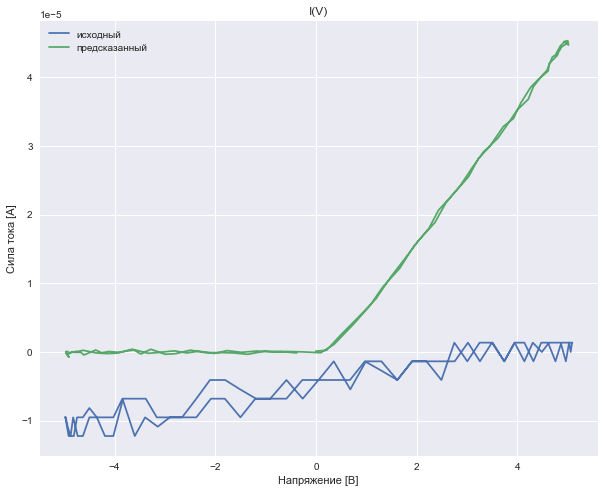

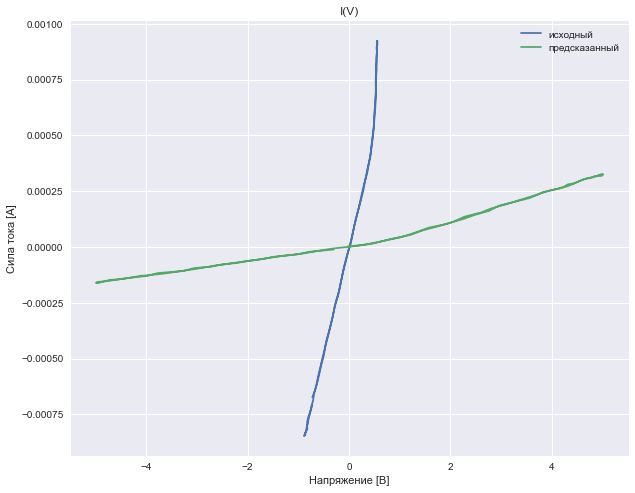

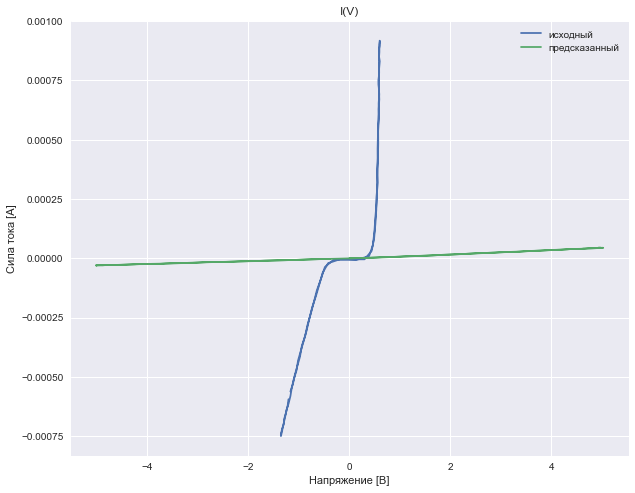

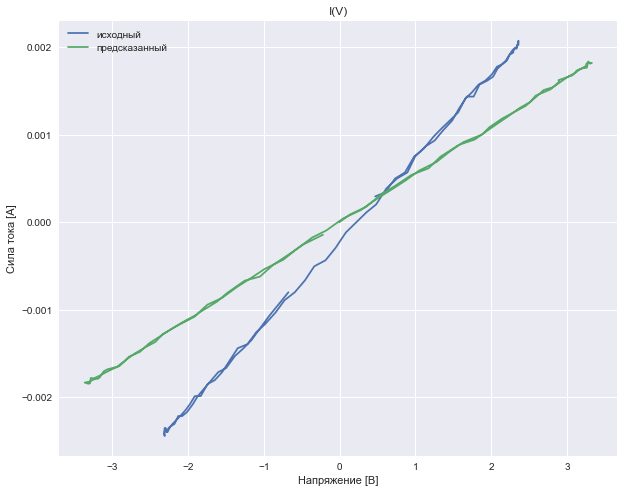

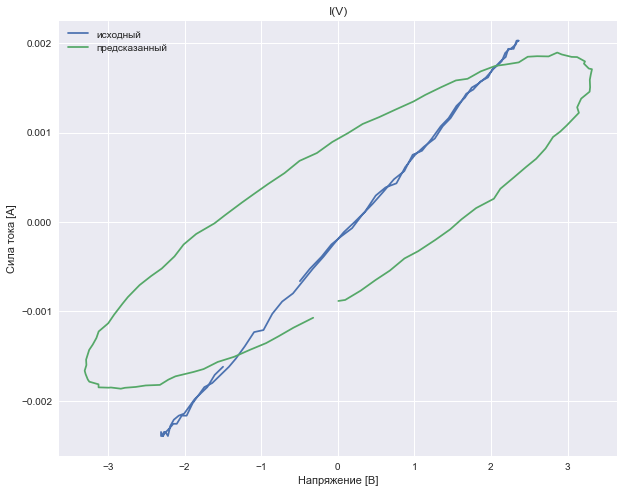

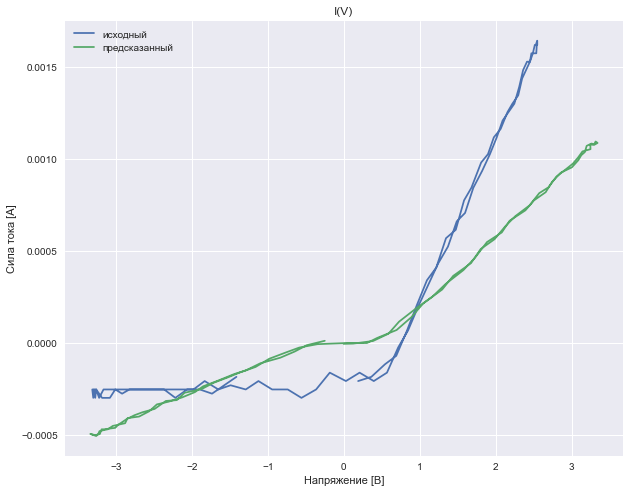

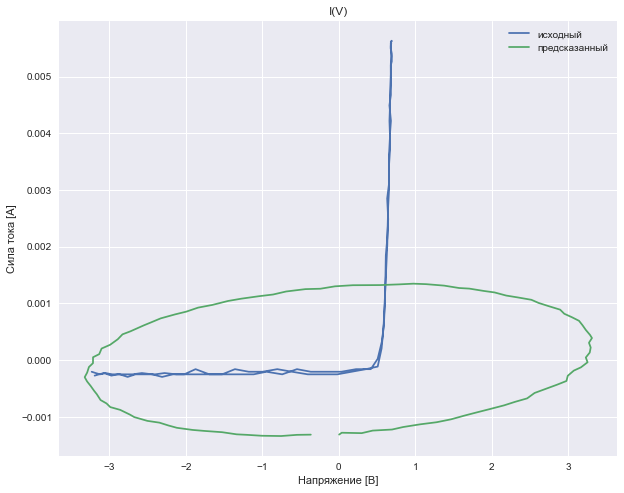

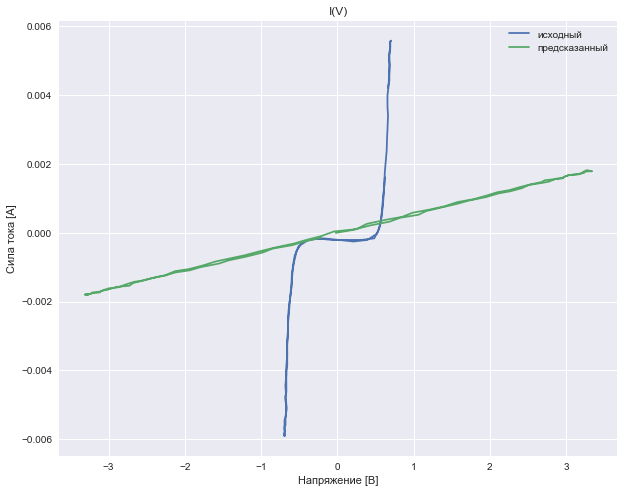

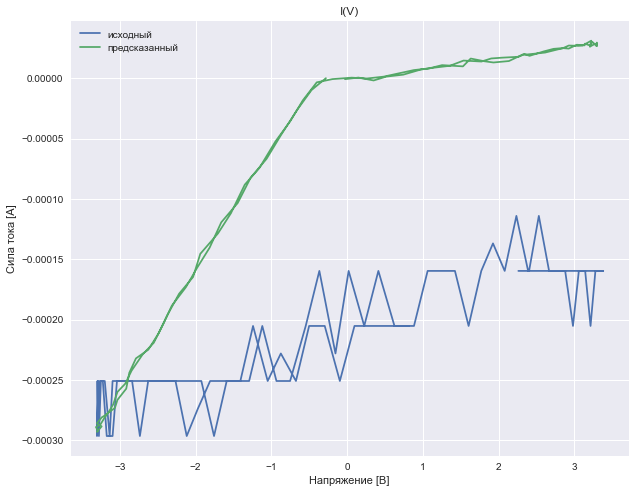

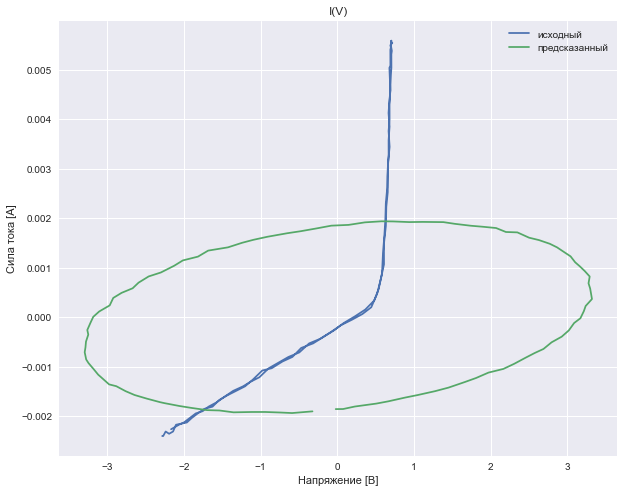

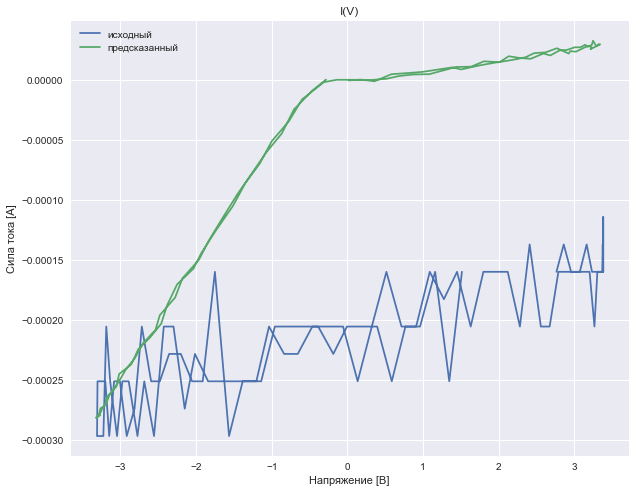

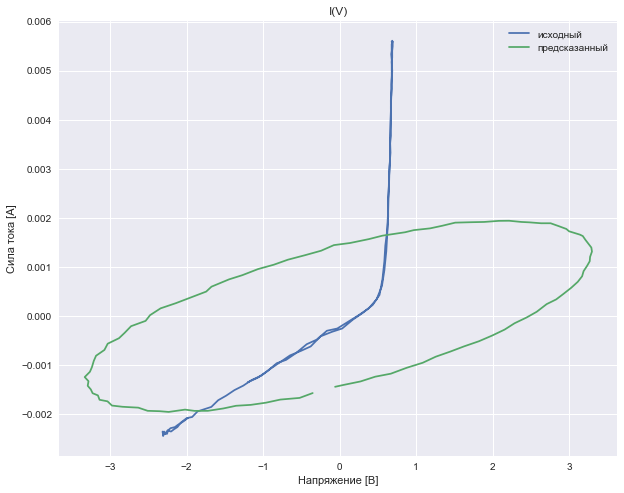

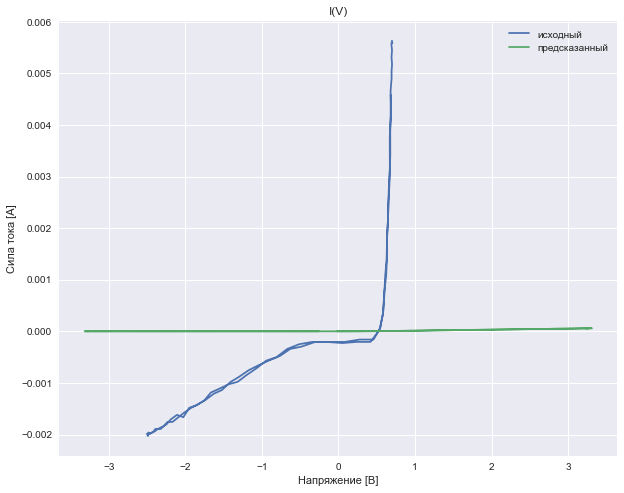

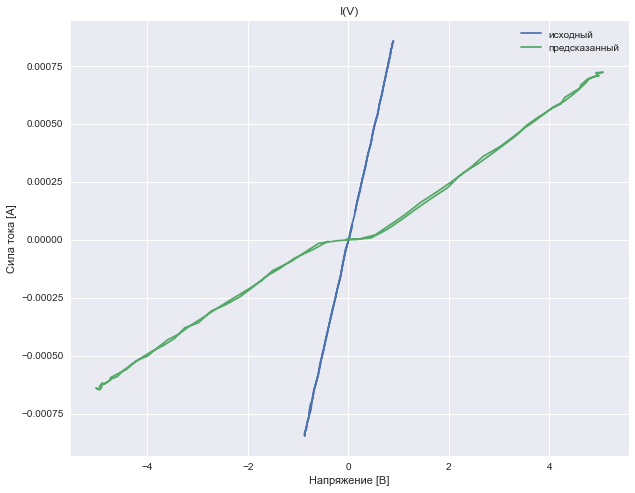

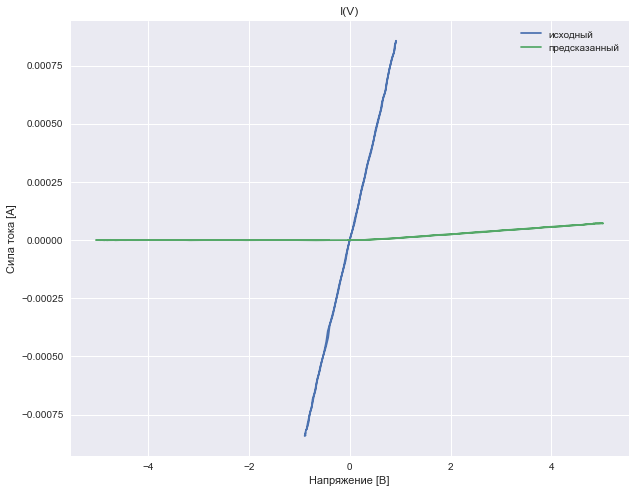

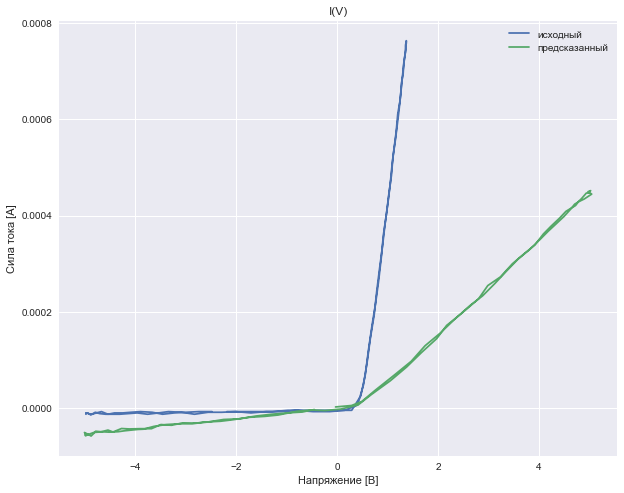

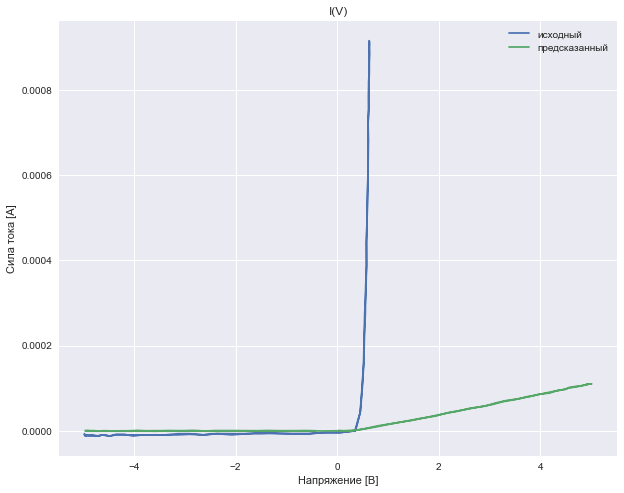

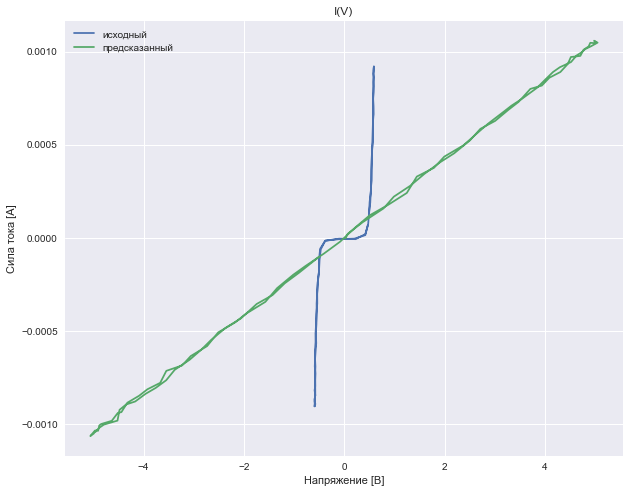

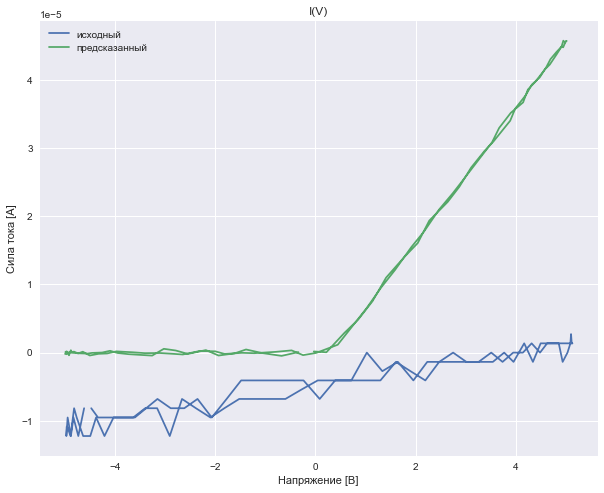

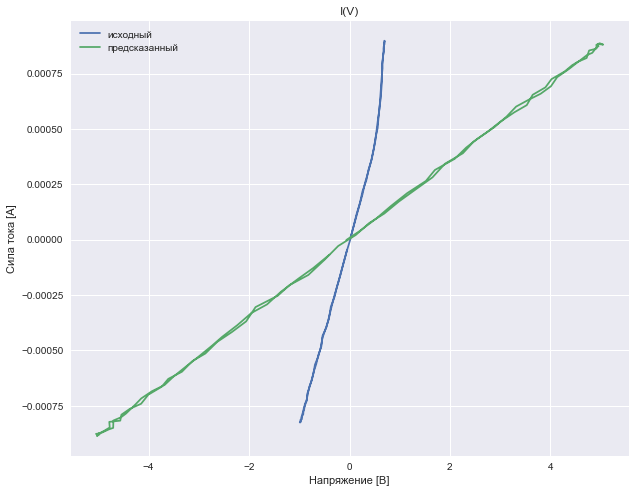

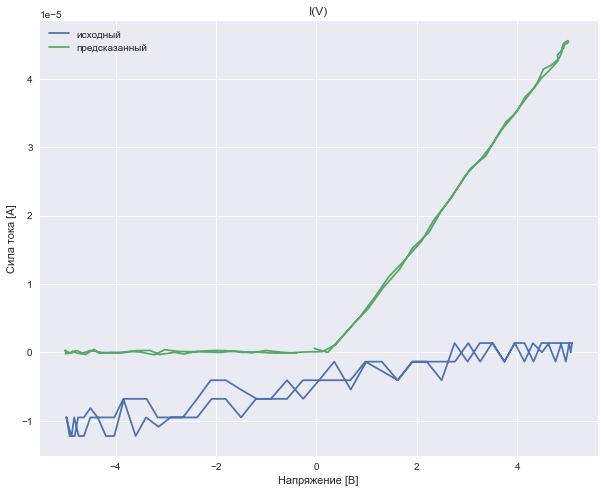

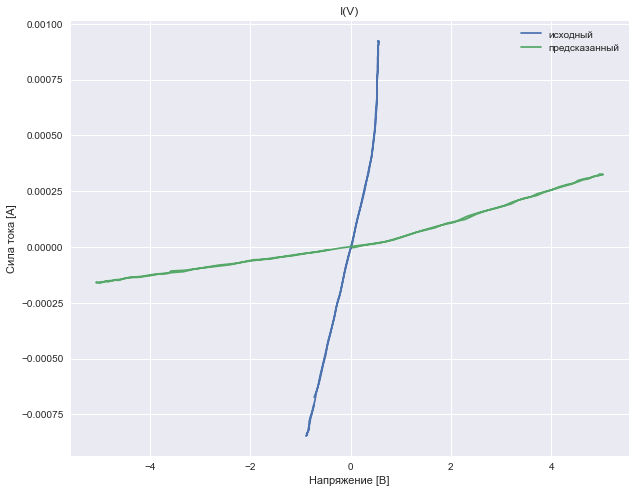

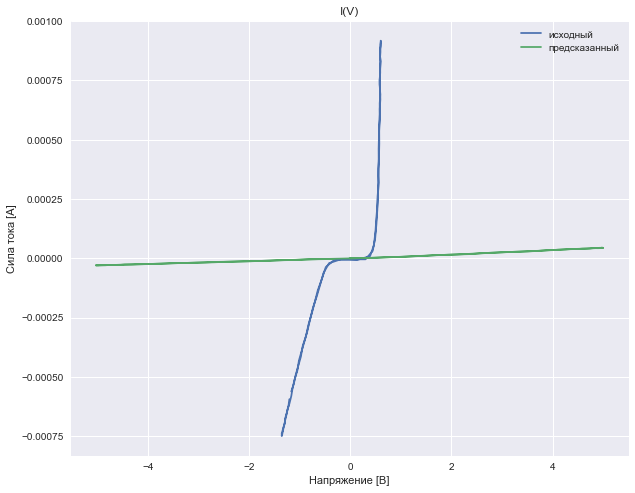

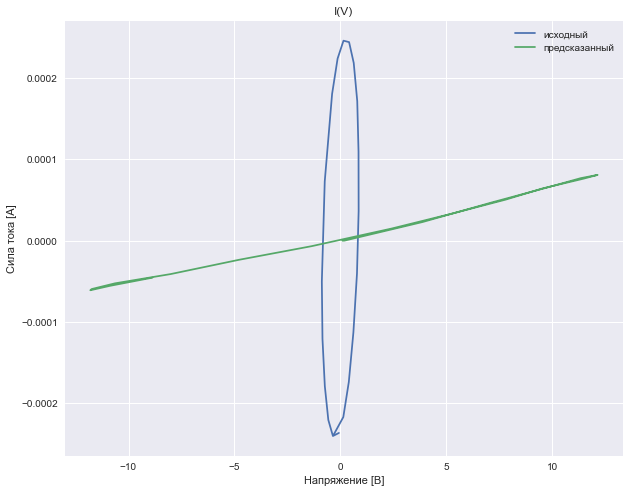

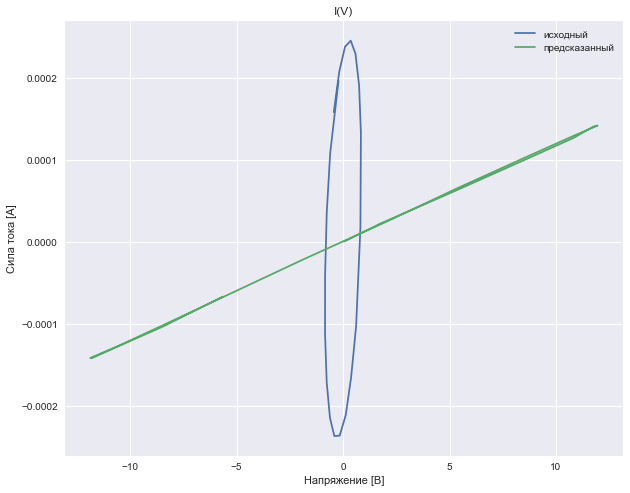

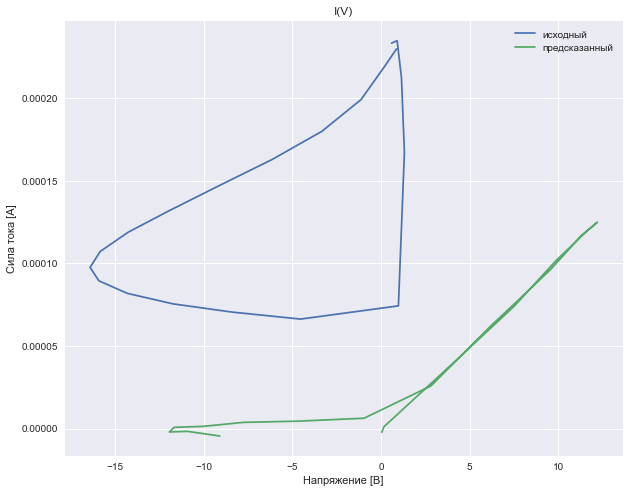

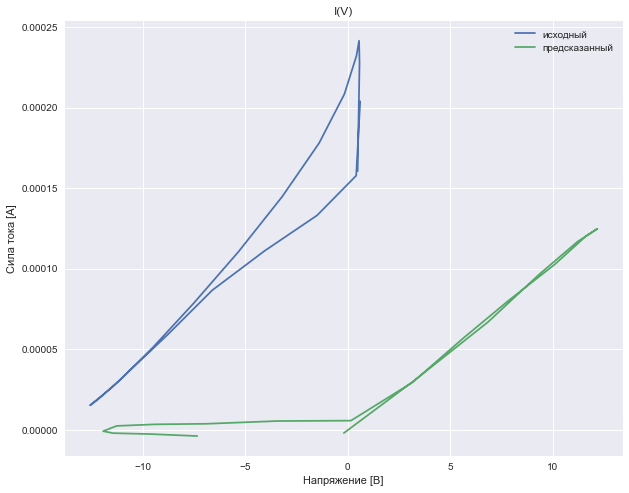

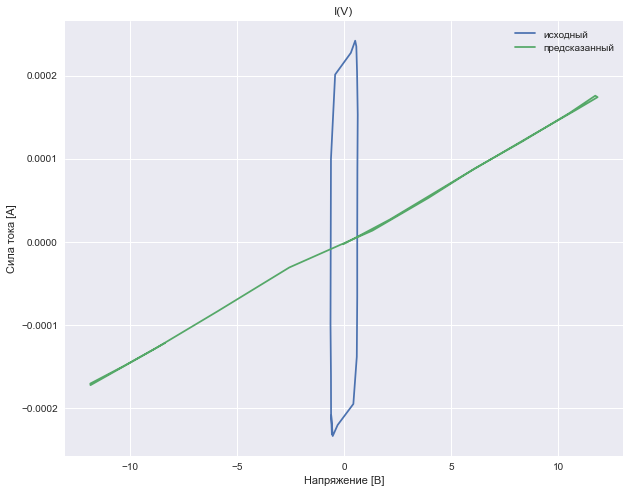

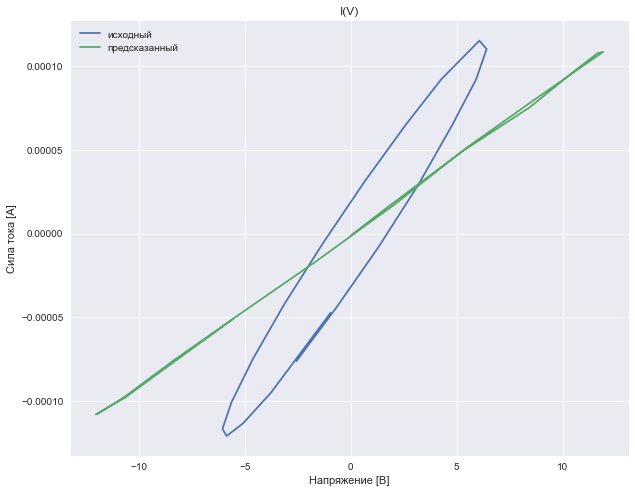

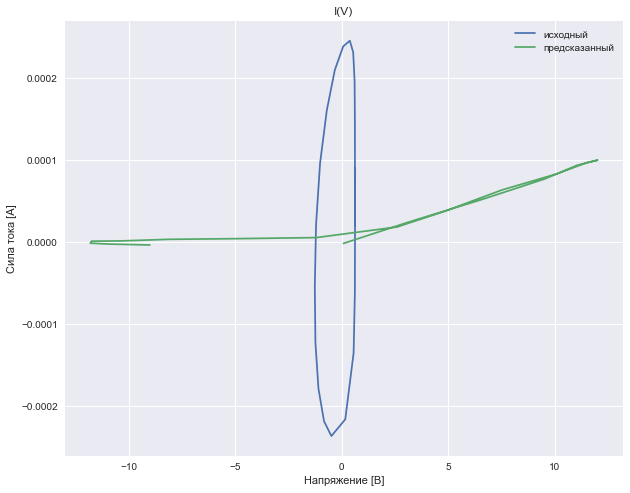

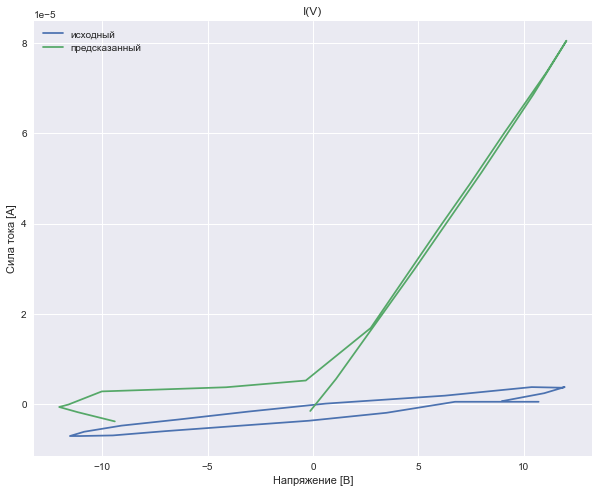

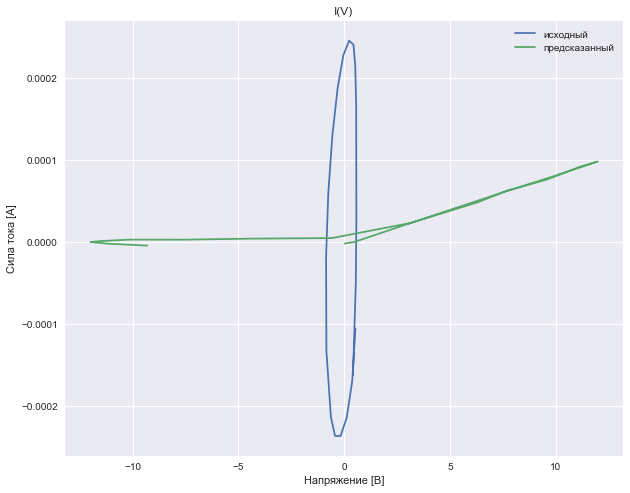

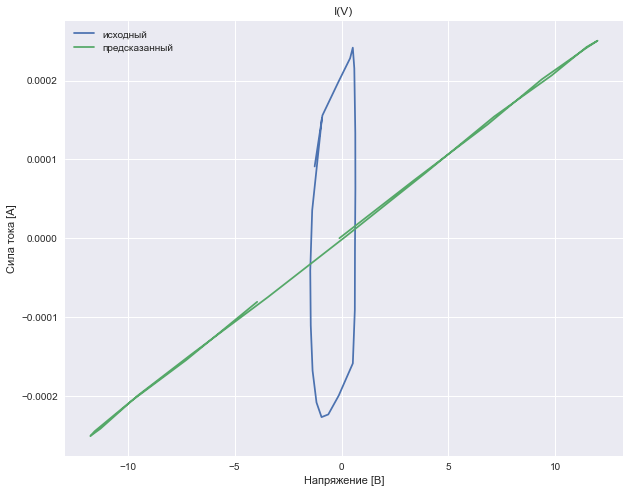

Wall time: 16.8 s


In [18]:
%%time
cre.test_all_json()